In [3147]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
from numba import jit
import classy
from tqdm import tqdm
import pickle
import numba
from scipy import interpolate
import scipy as sp
from itertools import combinations_with_replacement
import sys
sys.path.append('Library')
import base_funcs as bf
import scipy

In [3146]:
from FFTW import FFTW_fft_single as FFT_
from FFTW import FFTW_fft_single as FFT_
def FFTW_ifft(delta):
    #global iFFT_number
    #iFFT_number += 1
    threads=4
    return iFFT_(delta,threads)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size='22')
#plt.rcParams['figure.dpi'] = 150
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

In [1626]:
# so we need to convolve stuff

#so a pretty good approximation |k+q| approx sqrt(k^2 + q^2)
#we still have (k+q).x = k.x + q.x
#so we get expression for dipole as function of q.x - define on grid and times by W[q] - then FFT grid....


#so in the PP we can just use one FFT - inside we need to do sums of them similar to estimator as it x dependnet
@jit(nopython=True)
def mono_func(Pks,kk,ks,nu,b1=1):
    return Pks*b1**2 + 2*Pks*b1*f*(ks**2 + 3*nu**2)/(3*kk**2) + Pks*f**2*(ks**4 + 10*ks**2*nu**2 + 5*nu**4)/(5*kk**4)

def pk_mono_conv_pp1(qs,ks,t=0,b1=1):
    kk = np.sqrt(ks**2 + qs[0]**2+qs[1]**2+qs[2]**2)
    nu = qs[2]
    Pks = Pk_(kk)
    
    return  mono_func(Pks,kk,ks,nu,b1)

@jit(nopython=True)
def quad_func(Pks,nu,kk,ks,b1=1):
    return 4*Pks*f*ks**2*(7*b1*kk**2 + 3*f*(ks**2 + 7*nu**2))/(21*kk**4)


def pk_quad_conv_pp1(qs,ks,t=0,b1=1):
    kk = np.sqrt(ks**2 + qs[0]**2+qs[1]**2+qs[2]**2)
    nu = qs[2]
    Pks = Pk_(kk)
    
    return quad_func(Pks,nu,kk,ks)


In [3064]:
N_side=128
L=2000
Lwin =1000
f_s = L/Lwin #ratio of box to window
#define q grid #change the grid so have larger freq
q_sample = 2*np.pi*np.fft.fftfreq(N_side,d=(L/N_side))
qx,qy,qz = np.meshgrid(q_sample,q_sample,q_sample,indexing='ij')
q_norm = np.sqrt(qx**2+qy**2+qz**2)
q_norm = np.where(q_norm==0,1,q_norm)

#define d grid
d_sample = np.linspace(0,L,N_side)
dx,dy,dz = np.meshgrid(d_sample-L/2,d_sample-L/2,d_sample-L/2,indexing='ij')#these will be coordinates of the box and not of the observer

#lets create bool in the real space dimensions whether the voxel in the window or not...
In_window = np.where(np.logical_and(np.logical_and(np.abs(dx)<Lwin/2,np.abs(dy)<Lwin/2),np.abs(dz)<Lwin/2),True,False)

d_vec = np.array([dx,dy,dz])
qs = np.array([qx,qy,qz])

#get the window from the analytical FT of the cubic box...
def get_Wq(q_vec):
    L =1000
    return np.sinc(L*q_vec[0]/(2*np.pi))*np.sinc(L*q_vec[1]/(2*np.pi))*np.sinc(L*q_vec[2]/(2*np.pi))#(L/2)**3
wq = get_Wq([qx,qy,qz])*(N_side/f_s)**3#this is the correct normalisation when you ifft back
#print(np.sum(np.fft.ifftn(wq))/(N_side_th/f_s)**3)

In [2550]:
%%time
def get_pkfunc(l,eta,nu,verbose,*args):
    """Call functions which contains parts of pk"""
    #define which multipole
    if l==0:
        base = 'mono'
    elif l==1:
        base = 'dipo'
    elif l==2:
        base = 'quad'
    elif l==3:
        base = 'octo'
        
    function_name = base + f"{eta}{nu}" #get name of required function
    func_temp = globals().get(function_name)#get function defined previously of said name
    if func_temp==None:
        if verbose==True:
            print('No function for given values-'+base +f'{eta}{nu}')
        return [0]
    else:
        return func_temp(*args)
    

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 22.6 µs


In [2551]:
#so outside the PP 
def nu_terms(n,d_hat,q_vec):
    """Do the expansion of nu = q.d and return the fourier and real space components seperately.
    Expansion is implemented similar to code in estimator"""
    
    ind = np.array(list(combinations_with_replacement(np.arange(3), n)))
    
    #create arrays of coefficients that are paired together for the sum
    d_prod = np.zeros((len(ind),*d_hat[0].shape))
    q_prod = np.zeros((len(ind),*d_hat[0].shape))
    for i,inds in enumerate(ind):
        d_prod[i] = bf.count_distinct_permutations(inds)*np.prod(d_hat[inds],axis=0)
        q_prod[i] = np.prod(q_vec[inds],axis=0)
        

    return d_prod,q_prod


In [3048]:
def collect_pkconv(l,q_vec,d_vec,obs_pos,ks,t=0,eta_range=[0,4],verbose=False):
    """Will collate the convolved monopole from all terms with wide-angle corrections outside of the PP
    Different sections for differents orders of the expansion and different powers of nu"""
    d_vec = np.array([d_vec[i] - obs_pos[i] for i in range(3)]) #input observer
    d_norm = np.sqrt(np.sum(d_vec**2,axis=0))
    d_norm = np.where(d_norm==0,1,d_norm) #avoid 0 errors
    d_hat = d_vec/d_norm
    
    #do set up
    #kk = np.sqrt(ks**2 + q_vec[0]**2+q_vec[1]**2+q_vec[2]**2 + 2*ks*np.sqrt(q_vec[0]**2+q_vec[1]**2+q_vec[2]**2))
    kk = np.sqrt(ks**2 + q_vec[0]**2+q_vec[1]**2+q_vec[2]**2)
    kk = np.where(kk<1e-4,1e-4,kk)
    #get pks
    Pks = Pk_(kk)
    Pkd = Pk_d(kk)
    Pkdd = Pk_dd(kk)
    Pkddd = Pk_ddd(kk)
    
    pk_conv = np.complex64(0)#define pk_conv
    
    #lets think about a function
    def nu_func(pk_conv,eta,nu):
        """So here we compute the addition of any arbitary nu^n term at any order in eta"""
        
        temps_args = (Pks,Pkd,Pkdd,Pkddd,kk,ks,t)
            
        pk_terms_temp = get_pkfunc(l,eta,nu,verbose,*temps_args)#call required terms of pk
        if len(pk_terms_temp)==1: #for when there be no terms
            return pk_conv
        
        if nu == 0:    #nu0 terms
            pk_temp = FFTW_ifft(pk_terms_temp*wq)
            pk_conv += np.sum((np.fft.fftshift(pk_temp)/(d_norm**eta))[In_window])
        else: #nu != 0
            real_arr,fourier_arr = nu_terms(nu,d_hat,q_vec)
            for i in range(real_arr.shape[0]):
                pk_temp = FFTW_ifft(fourier_arr[i]*pk_terms_temp*wq) #ifft
                pk_conv += np.sum((real_arr[i]*np.fft.fftshift(pk_temp)/(d_norm**(eta)))[In_window]) #sum parts in window
        return pk_conv

    for eta in range(eta_range[0],eta_range[1]):
        for nu in range(2,3):
            pk_conv = nu_func(pk_conv,eta,nu)

    return pk_conv/np.sum(In_window)
pk_temp = collect_pkconv(1,qs,d_vec,(0,0,1000),0.05,0,[1,2],True)


In [3121]:
def real_ccc(q_vec,ks):
    kk = np.sqrt(ks**2 + q_vec[0]**2+q_vec[1]**2+q_vec[2]**2)
    kk = np.where(kk<1e-4,1e-4,kk)
    return Pk_(kk)

In [3125]:
pk_temp = FFTW_ifft(real_ccc(qs,0.1)*wq)
pk_conv = np.sum(np.fft.fftshift(pk_temp)[In_window]) #sum parts in window
print(pk_conv)

(1439897100-4.0469055j)


In [3127]:
pk_temp = FFTW_ifft(real_ccc(qs,0.1)*wq**2)
pk_conv = np.sum(np.fft.fftshift(pk_temp)) #sum parts in window
print(pk_conv)

(389450900000000-0.16357422j)


In [2778]:
obs_pos = (0,0,0)

In [2625]:
def plot_convolved(k_plot,l,obs_pos=(0,0,0),t=0,eta_range=[0,3]):
    plots = np.zeros(len(k_plot),dtype=np.complex64)
    for i in tqdm(range(len(k_plot))):
        plots[i]= (collect_pkconv(l,qs,d_vec,obs_pos,k_plot[i],t,eta_range))
    return plots

In [3043]:
#for quad testing
quad_pk2_64 = (plot_convolved(kk_,2,(0,0,0),t=0,eta_range=[2,3]))#+plot_convolved(kk_,2,(0,0,0),t=0,eta_range=[0,1]))/2
#mono_pk0_64 = (plot_convolved(kk_,0,(0,0,0),t=0,eta_range=[0,1]))#+plot_convolved(kk_,0,(0,0,0),t=0,eta_range=[0,1]))/2


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


No handles with labels found to put in legend.


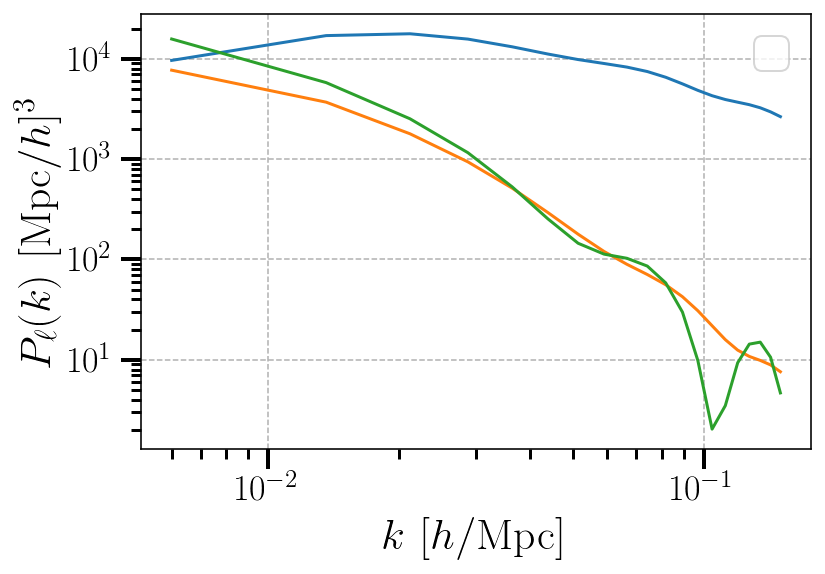

In [3046]:
#plt.plot(kk_,mono_pk0_64.real)
#plt.plot(kk_,np.abs(mono_pk1_64.real))
#plt.plot(kk_,np.abs(mono_pk2_64.real))

plt.plot(kk_,quad_pk0_64.real)
plt.plot(kk_,(quad_pk1_64.real))
plt.plot(kk_,-(quad_pk2_64.real))


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{\ell}(k)\,\,[\mathrm{Mpc}/h]^3$')
plt.legend()
plt.grid(ls='--',lw=0.75)

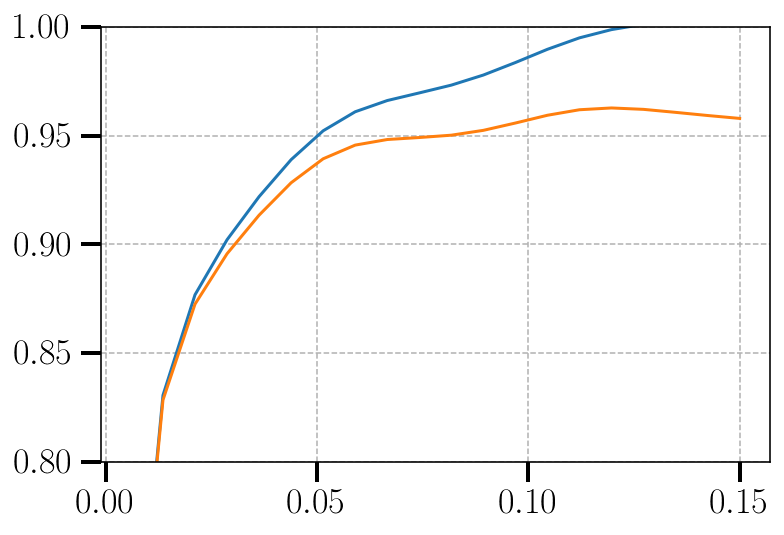

In [3008]:
plt.plot(kk_,(1+0.4*kk_)*(quad_pk1_64.real)/pk_quad_dfog(kk_,sigma))
plt.plot(kk_,(quad_pk1_128.real)/pk_quad_dfog(kk_,sigma))
plt.ylim(0.8,1)
plt.grid(ls='--',lw=0.75)

In [2938]:
kk_ = np.linspace(0.006,0.15,20)
temp_pk1_64 = (plot_convolved(kk_,3,(0,0,700),t=0,eta_range=[0,1])+plot_convolved(kk_,3,(0,0,-700),t=0,eta_range=[0,1]))/2
temp_pk2_64 = (plot_convolved(kk_,3,(0,0,700),t=0,eta_range=[1,2])+plot_convolved(kk_,3,(0,0,-700),t=0,eta_range=[1,2]))/2
temp_pk3_64 = (plot_convolved(kk_,3,(0,0,700),t=0,eta_range=[2,3])+plot_convolved(kk_,3,(0,0,-700),t=0,eta_range=[2,3]))/2
temp_pk4_64 = (plot_convolved(kk_,3,(0,0,700),t=0,eta_range=[3,4])+plot_convolved(kk_,3,(0,0,-700),t=0,eta_range=[3,4]))/2


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


No handles with labels found to put in legend.


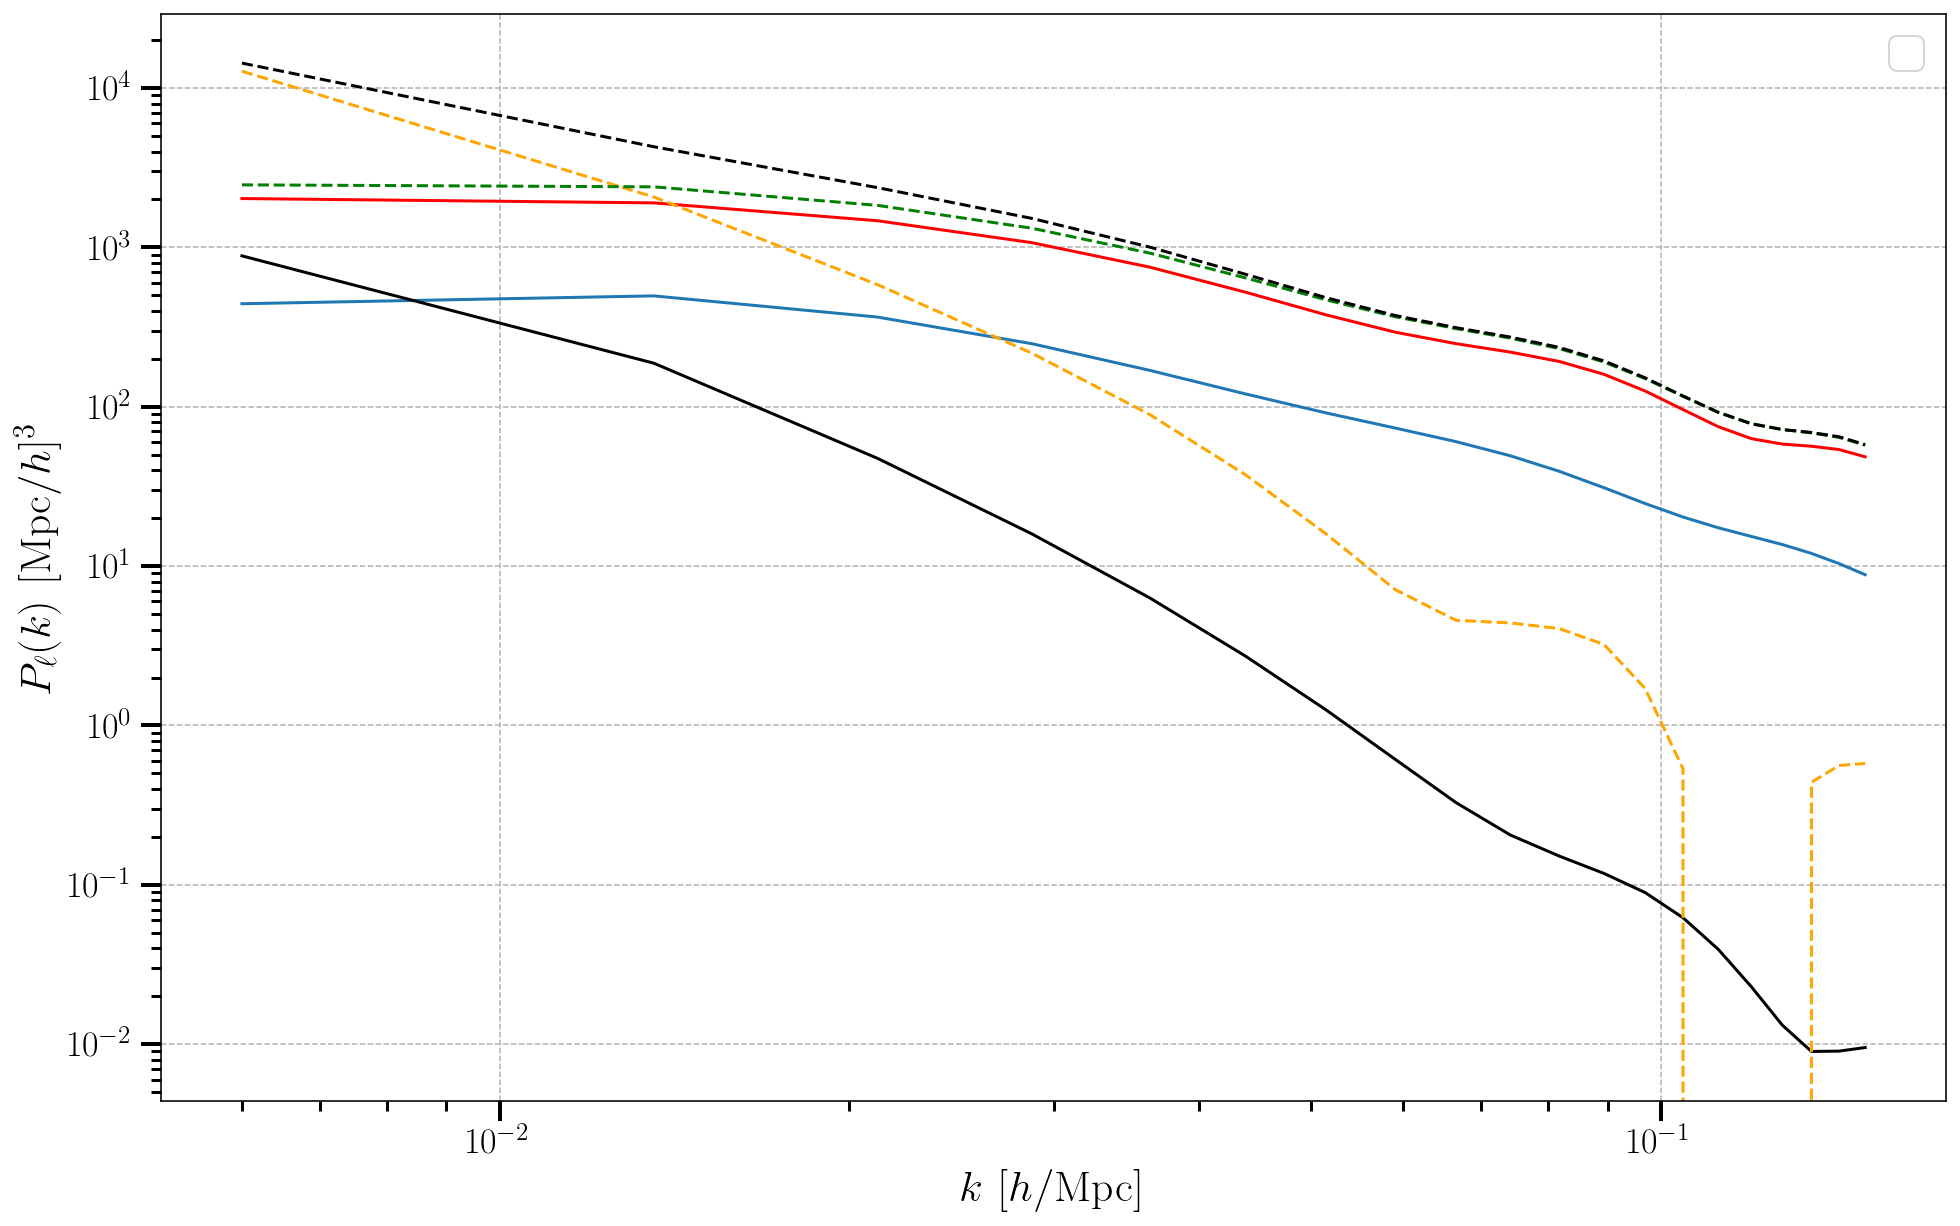

In [2941]:
plt.figure(figsize=(16,10))

plt.plot(kk_,(temp_pk1.imag))
#plt.plot(kk_,(temp_pk1_128.imag))
#plt.plot(kk_,(temp_pk1_256.imag))

plt.plot(kk_,-(temp_pk2.imag),color='red')
#plt.plot(kk_,-(temp_pk2_128.imag),color='red')
#plt.plot(kk_,-(temp_pk2_256.imag),color='red')
#plt.plot(kk_,-(temp_pk2.imag)+(temp_pk1.imag))

plt.plot(kk_,-(temp_pk3_64.imag),'k')
#plt.plot(kk_,(temp_pk3_128.imag))

plt.plot(kk_,(temp_pk4_64.imag),'--',color='orange')
plt.plot(kk_,-(-(temp_pk1.imag)+(temp_pk2.imag)),color='green',linestyle='--')
plt.plot(kk_,-(-(temp_pk1.imag)+(temp_pk2.imag)-(temp_pk3_64.imag)-temp_pk4_64.imag),'k',linestyle='--')

#plt.plot(kk_,-pk_octo(kk_,1000,0).imag,'--',color='black')
#plt.plot(k_plots,-pk_dipo_dfog_wa(k_plots,5,500,0).imag)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{\ell}(k)\,\,[\mathrm{Mpc}/h]^3$')
plt.legend()
plt.grid(ls='--',lw=0.75)

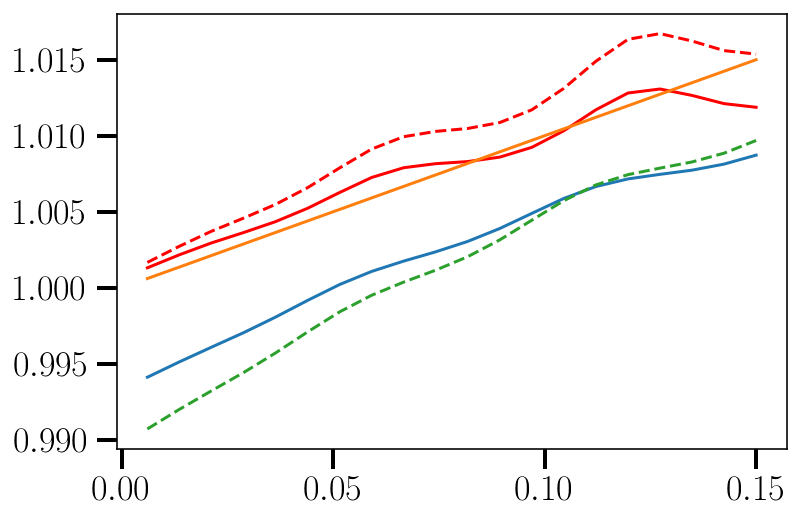

In [2881]:
plt.plot(kk_,(temp_pk1_128.imag)/(temp_pk1.imag))
plt.plot(kk_,(temp_pk2_128.imag)/(temp_pk2.imag),color='red')
plt.plot(kk_,(1+0.1*kk_))
plt.plot(kk_,(temp_pk1_256.imag)/(temp_pk1.imag),'--')
plt.plot(kk_,(temp_pk2_256.imag)/(temp_pk2.imag),'--',color='red')

In [2798]:
k_plots = np.linspace(0.006,0.4,20)
dfdipo14 = plot_convolved(k_plots,1,(0,0,0),t=0,eta_range=[1,2])

100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


No handles with labels found to put in legend.


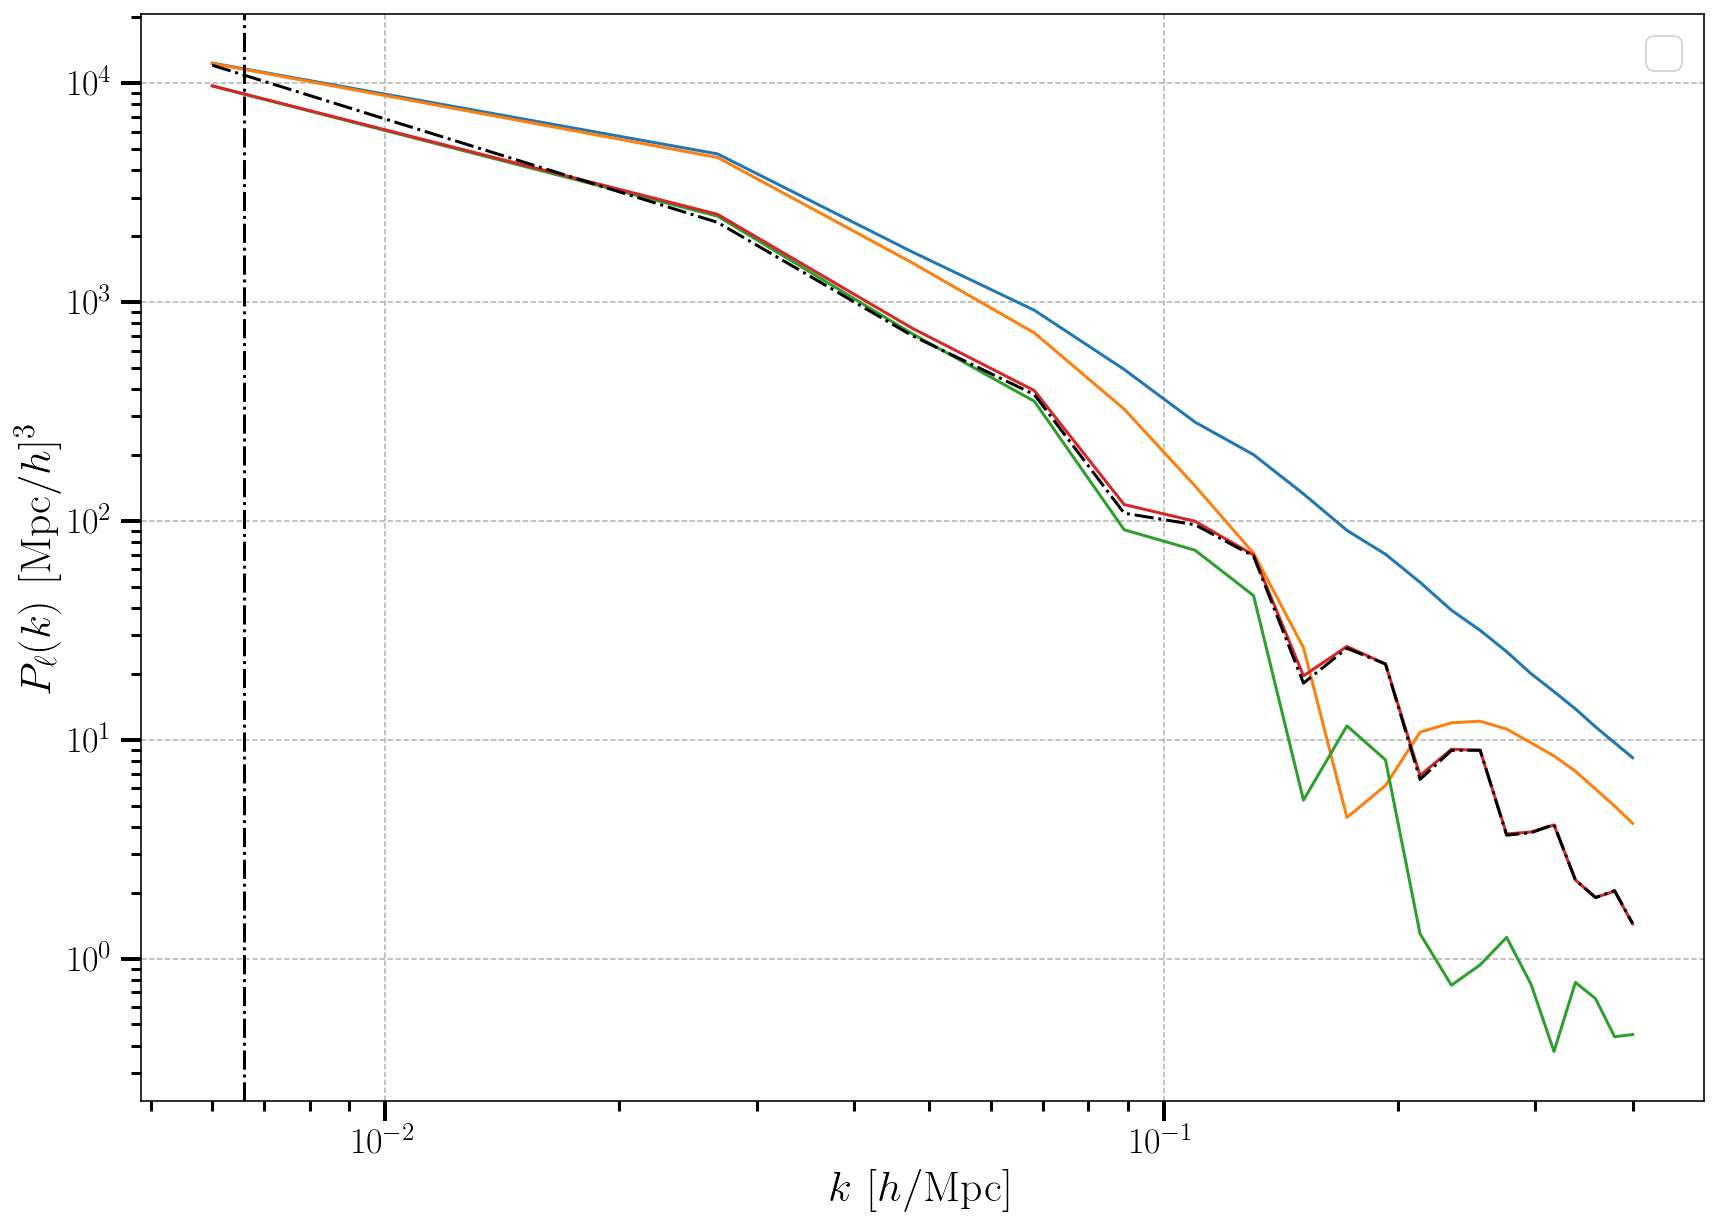

In [2830]:
plt.figure(figsize=(14,10))

#because we have discrete sampling we need to make tiny correction - a bit hacky but 512 grids will be a bit much outside PP
#with fog
#plt.plot(k_plots,np.abs(dipo1.imag),color='blue',linestyle='--')
#plt.plot(k_plots,np.abs(dipo3.imag),color='green',linestyle='--')
#plt.plot(k_plots,np.abs(dipo5.imag),color='red',linestyle='--')
#without fog
#plt.plot(k_plots,np.abs(dipo1_.imag),color='blue',linestyle='-.')
#plt.plot(k_plots,np.abs(dipo3_.imag),color='green',linestyle='-.')
#plt.plot(k_plots,np.abs(dipo5_.imag),color='red',linestyle='-.')

plt.plot(k_plots,np.abs(dipo1_.imag+dipo3_.imag+dipo5_.imag))
plt.plot(k_plots,np.abs(dipo1.imag+dipo3.imag+dipo5.imag))


#eta =1
#with fog
#plt.plot(k_plots,np.abs(dfdipo10.imag),color='blue',linestyle='--')
#plt.plot(k_plots,np.abs(dfdipo12.imag),color='green',linestyle='--')
#plt.plot(k_plots,np.abs(dfdipo14.imag),color='red',linestyle='--')
plt.plot(k_plots,np.abs(dfdipo10.imag+dfdipo12.imag+dfdipo14.imag))

#without fog
#plt.plot(k_plots,np.abs(dipo10_.imag),color='blue',linestyle='-.')
#plt.plot(k_plots,np.abs(dipo12_.imag),color='green',linestyle='-.')
#plt.plot(k_plots,np.abs(dipo14_.imag),color='red',linestyle='-.')
plt.plot(k_plots,np.abs(dipo10_.imag+dipo12_.imag+dipo14_.imag))

#plt.plot(k_plots,(dipo1_.imag+dipo3_.imag+dipo5_.imag)+(dipo10_.imag+dipo12_.imag+dipo14_.imag))
#plt.plot(k_plots,(dipo1.imag+dipo3.imag+dipo5.imag)+(dfdipo10.imag+dfdipo12.imag+dfdipo14.imag))

plt.plot(k_plots,pk_dipo(k_plots,430,0),'-.',color= 'k')
#plt.plot(k_plots,-pk_dipo_dfog_wa(k_plots,5,430,0).imag,'-.',color= 'k')

plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{\ell}(k)\,\,[\mathrm{Mpc}/h]^3$')
plt.axvline(x = 0.0066, linestyle='-.', color = 'black')
#plt.axvline(x = 0., linestyle='-.', color = 'black')
#plt.ylim(0.84,1)
#plt.xlim(9e-3,0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(ls='--',lw=0.75)
plt.show()


In [3083]:
k_plots = np.linspace(0.006,0.6,50)
#monopp_1281 = plot_convolved(k_plots,0,(0,0,0),t=0,eta_range=[0,1])

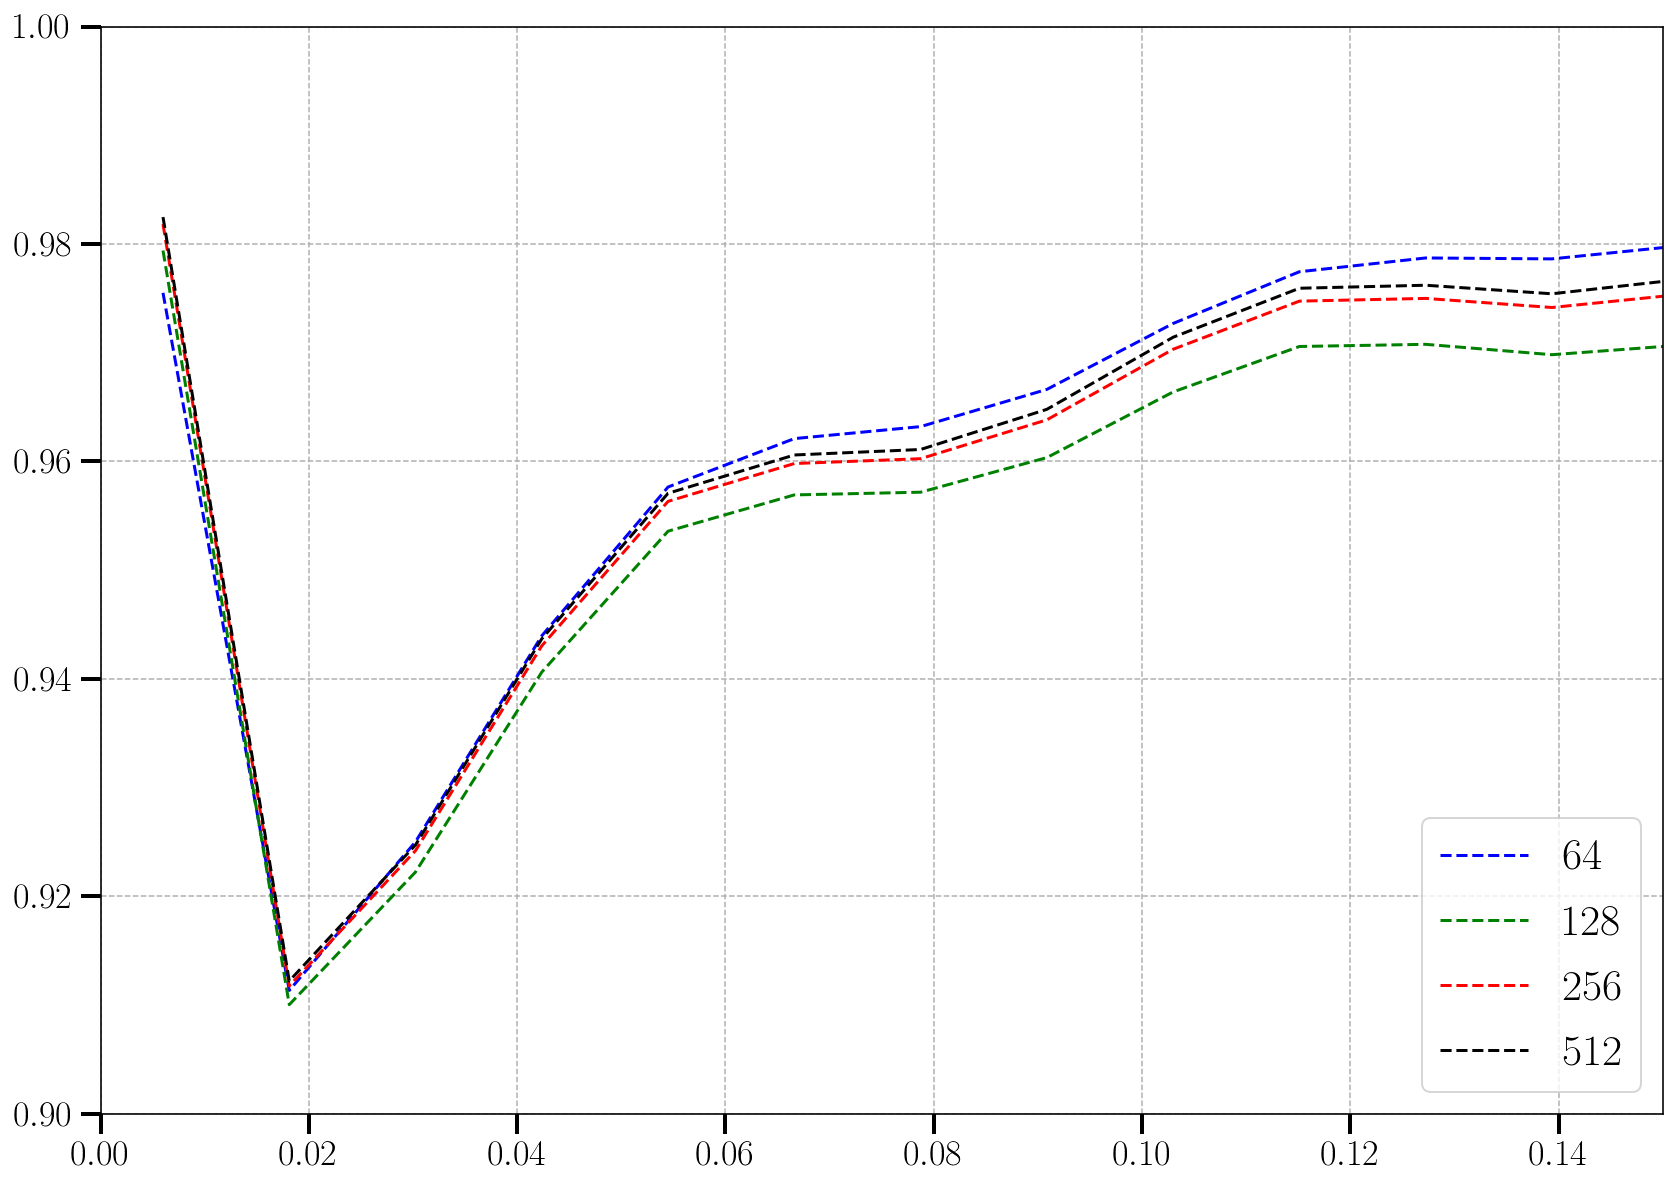

In [3144]:
plt.figure(figsize=(14,10))

plt.plot(k_plots,(1 +0.06*np.sqrt(k_plots))*monopp_64.real/pk_mono(k_plots,5),label='64',color='blue',linestyle='--')
plt.plot(k_plots,(1 +0.0*np.sqrt(k_plots))*monopp_128.real/pk_mono(k_plots,5),label='128',color='green',linestyle='--')
#plt.plot(k_plots,(1 +0.0*k_plots1)*monopp_1281.real/pk_mono(k_plots1,5),color='green',linestyle='-')
plt.plot(k_plots,(1 +0.0*k_plots)*monopp_256.real/pk_mono(k_plots,5),label='256',color='red',linestyle='--')
plt.plot(k_plots,(1 +0.0*k_plots)*monopp_512.real/pk_mono(k_plots,5),label='512',color='black',linestyle='--')
plt.legend()
plt.ylim(0.90,1)
plt.xlim(0,0.15)
plt.grid(ls='--',lw=0.75)

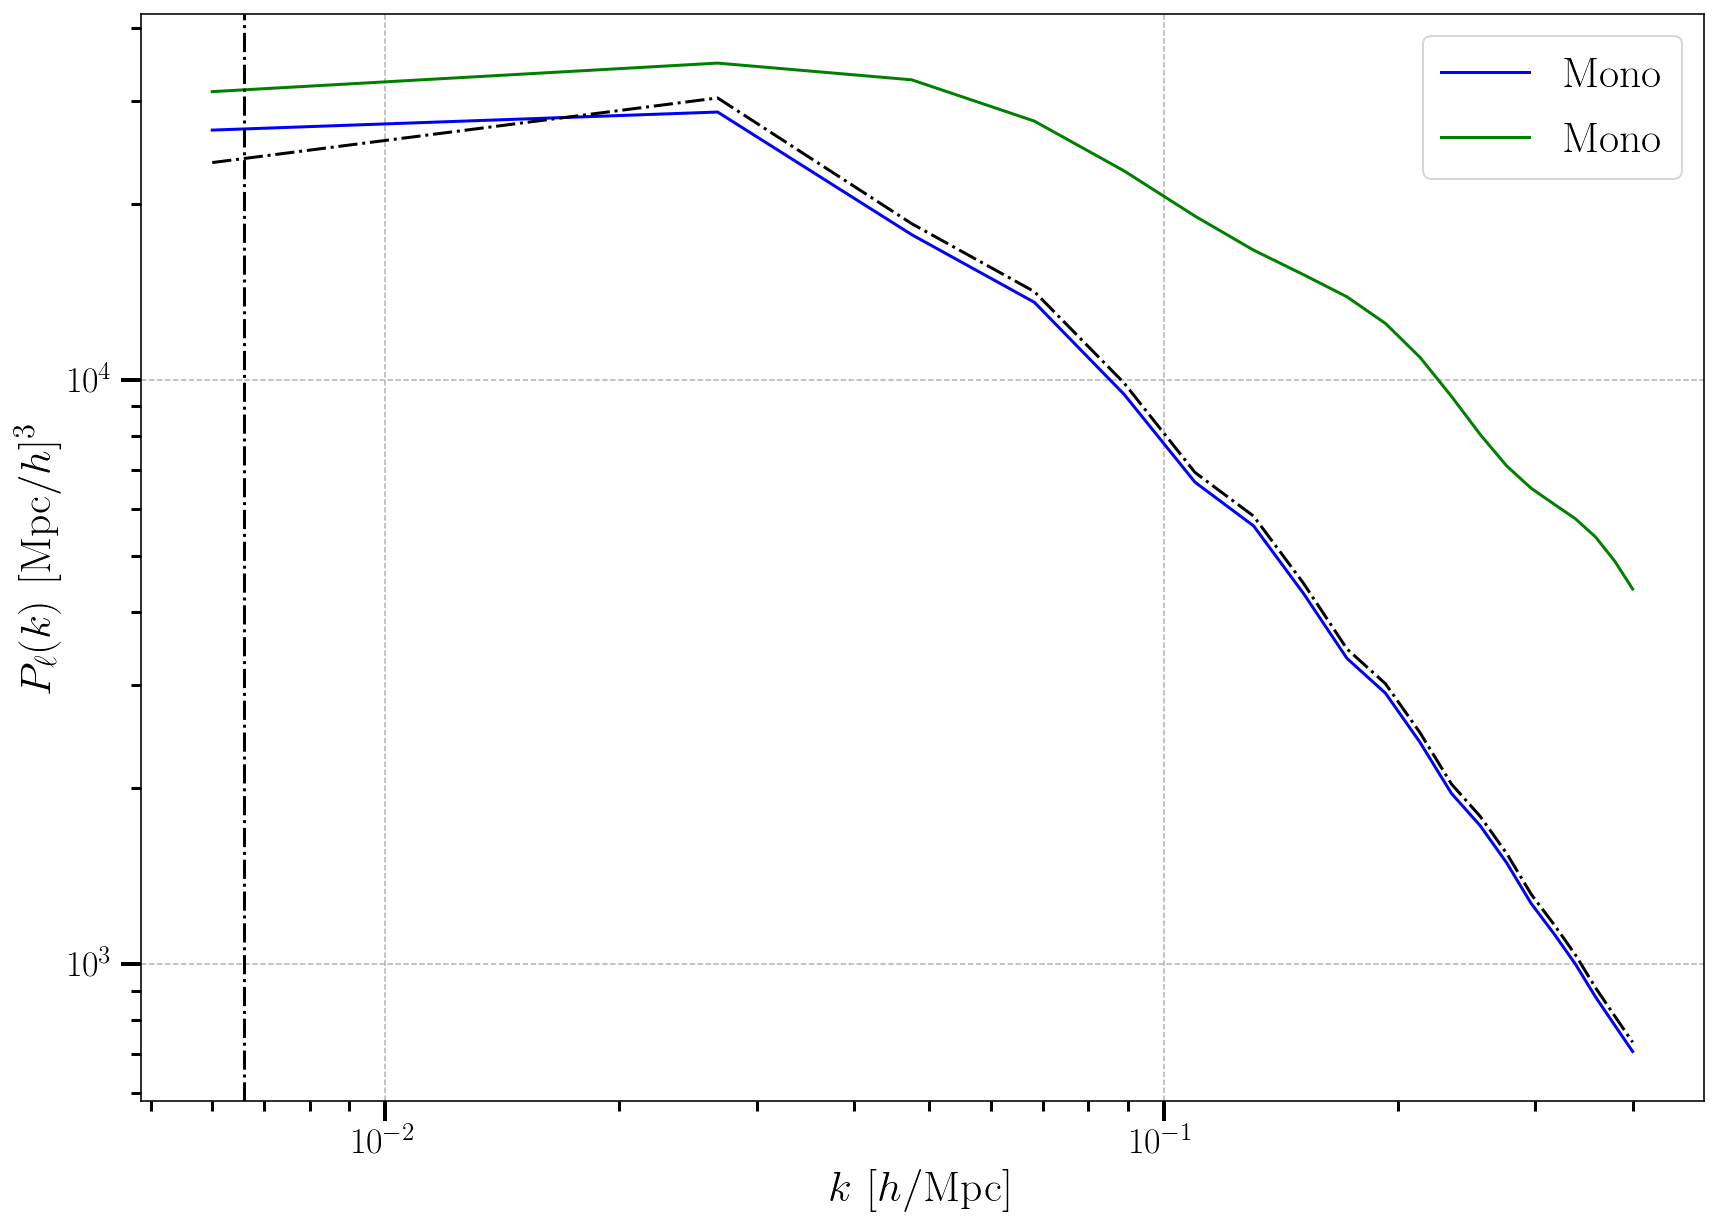

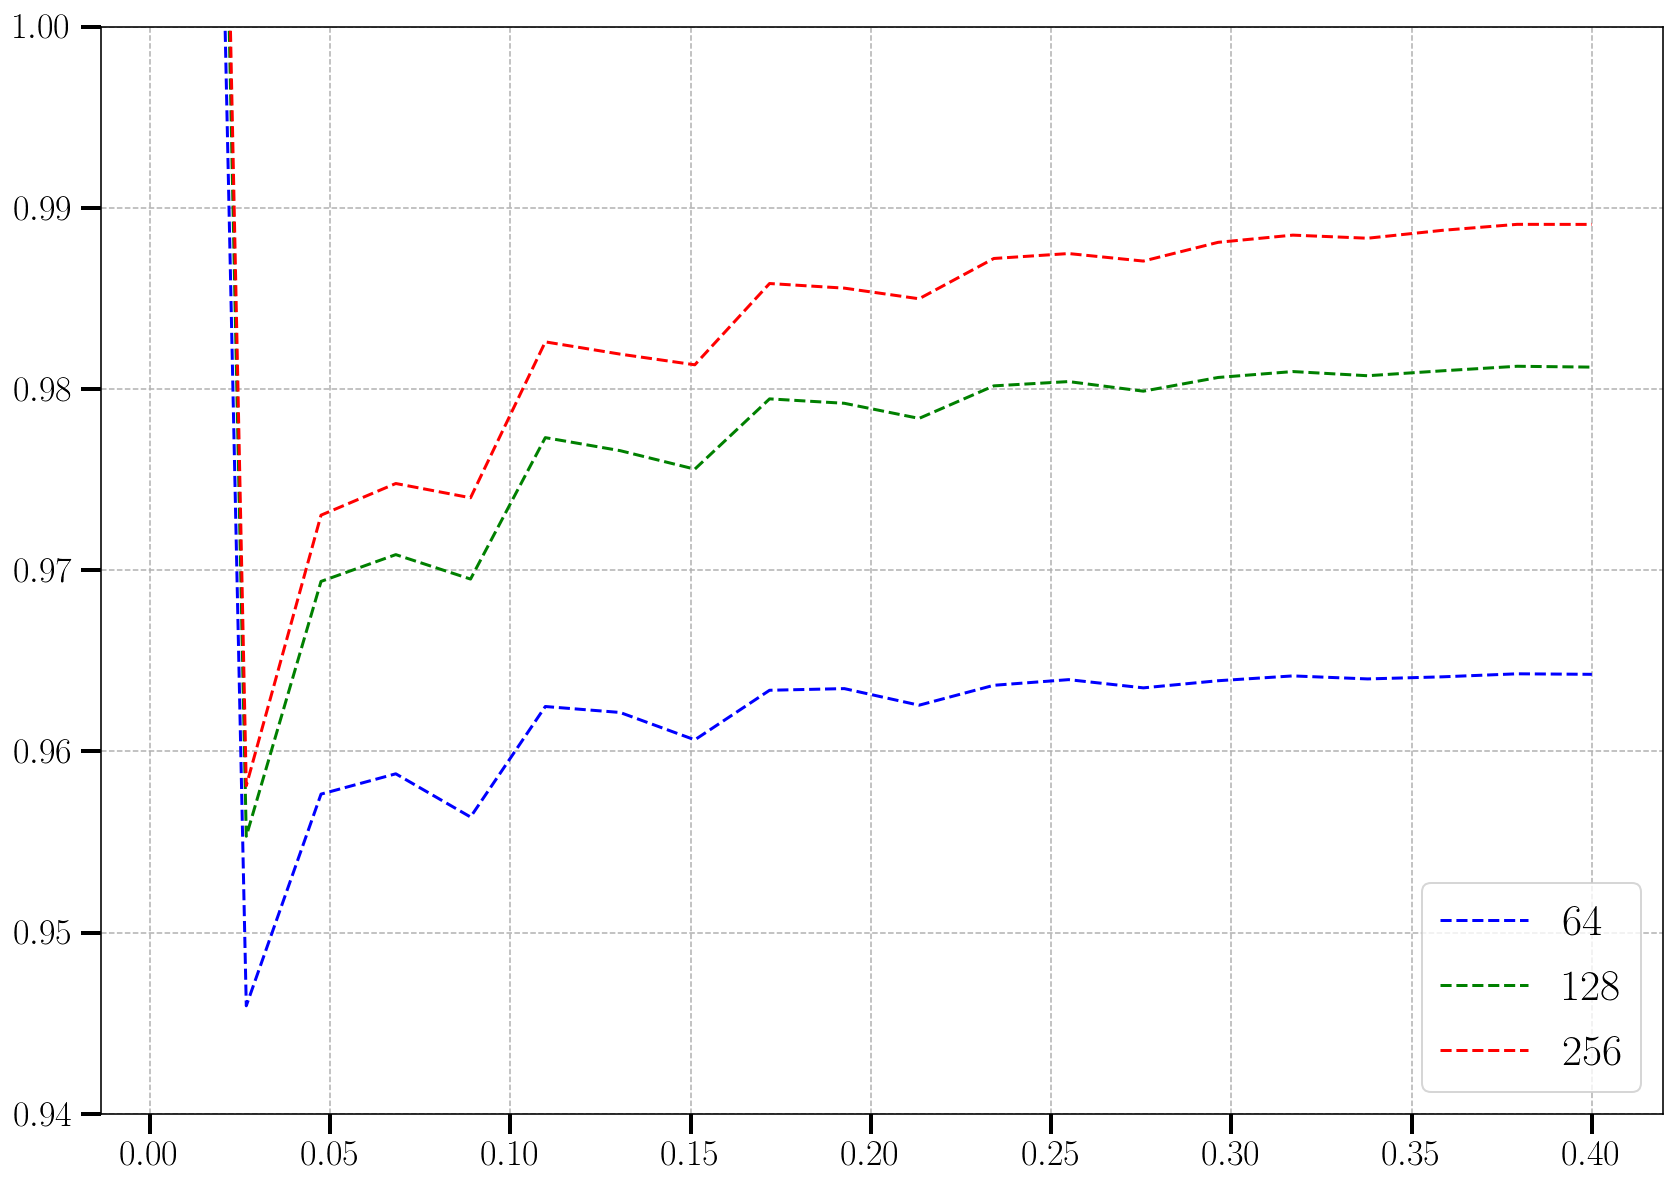

In [3047]:
plt.figure(figsize=(14,10))

#because we have discrete sampling we need to make tiny correction - a bit hacky but 512 grids will be a bit much outside PP
plt.plot(k_plots,(1 +0.0*k_plots)*mono1_64.real,label='Mono',color='blue')
plt.plot(k_plots,(1 +0.0*k_plots)*mono2.real,label='Mono',color='green')
#plt.plot(k_plots,(1 +0.00*k_plots)*mono1_128.real,label='Mono',color='green',linestyle='--')
#plt.plot(k_plots,(1 +0.00*k_plots)*mono1_256.real,label='Mono',color='red',linestyle='--')
#plt.plot(k_plots,(1 +0.00*k_plots)*mono2_.real,label='Mono',color='green',linestyle='--')
plt.plot(k_plots,pk_mono(k_plots,5),'-.',color= 'k')

plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{\ell}(k)\,\,[\mathrm{Mpc}/h]^3$')
plt.axvline(x = 0.0066, linestyle='-.', color = 'black')
#plt.axvline(x = 0., linestyle='-.', color = 'black')
#plt.ylim(0.84,1)
#plt.xlim(9e-3,0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(ls='--',lw=0.75)
plt.show()

In [ ]:
"""
#add more baby
#ok we start with "full" inifnitee nu expansion fog
sigma=5
#@jit(nopython=True)#these are kinda dfog affected but it weird
def dipo01(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return -3*Pks*nu*(2*np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*sigma*(4*b1**2*kk**4*sigma**4 + 4*b1*f*kk**2*sigma**2 + 3*f**2) - 4*np.exp(-ks**2*sigma**2)*ks*sigma**2*(4*b1**2*kk**4*sigma**4 + 8*b1*f*kk**2*ks**2*sigma**4 + 4*b1*f*kk**2*sigma**2 + 4*f**2*ks**4*sigma**4 + 2*f**2*ks**2*sigma**2 + 3*f**2))/(16*kk**4*ks**2*sigma**6)
#@jit(nopython=True)
def dipo03(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return 2*Pks*np.exp(-ks**2*sigma**2)*ks*nu**3*(b1**2*kk**4*sigma**4 + 2*b1*f*kk**2*ks**2*sigma**4 - 4*b1*f*kk**2*sigma**2 + f**2*ks**4*sigma**4 - 4*f**2*ks**2*sigma**2 + 2*f**2)/kk**4
def dipo05(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return Pks*np.exp(-ks**2*sigma**2)*ks*nu**5*sigma**2*(2*b1**2*kk**4*ks**2*sigma**6 - 5*b1**2*kk**4*sigma**4 + 4*b1*f*kk**2*ks**4*sigma**6 - 26*b1*f*kk**2*ks**2*sigma**4 + 30*b1*f*kk**2*sigma**2 + 2*f**2*ks**6*sigma**6 - 21*f**2*ks**4*sigma**4 + 54*f**2*ks**2*sigma**2 - 30*f**2)/(5*kk**4)

#1st order ----------------------------------
#@jit(nopython=True)
def dipo14(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -1j*np.exp(-ks**2*sigma**2)*f*ks*nu**4*(2*t - 1)*(2*Pkd*b1*kk**5*ks**2*sigma**6 - 5*Pkd*b1*kk**5*sigma**4 - 2*Pkd*b1*kk**3*ks**4*sigma**6 + 11*Pkd*b1*kk**3*ks**2*sigma**4 - 10*Pkd*b1*kk**3*sigma**2 + 2*Pkd*f*kk**3*ks**4*sigma**6 - 11*Pkd*f*kk**3*ks**2*sigma**4 + 10*Pkd*f*kk**3*sigma**2 - 2*Pkd*f*kk*ks**6*sigma**6 + 17*Pkd*f*kk*ks**4*sigma**4 - 32*Pkd*f*kk*ks**2*sigma**2 + 10*Pkd*f*kk + 4*Pks*b1*kk**2*ks**4*sigma**6 - 22*Pks*b1*kk**2*ks**2*sigma**4 + 20*Pks*b1*kk**2*sigma**2 - 4*Pks*f*kk**2*ks**4*sigma**6 + 22*Pks*f*kk**2*ks**2*sigma**4 - 20*Pks*f*kk**2*sigma**2 + 8*Pks*f*ks**6*sigma**6 - 68*Pks*f*ks**4*sigma**4 + 128*Pks*f*ks**2*sigma**2 - 40*Pks*f)/(d*kk**6)
#@jit(nopython=True)
def dipo12(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -6*1j*np.exp(-ks**2*sigma**2)*f*ks*nu**2*(2*t - 1)*(Pkd*b1*kk**5*sigma**2 - Pkd*b1*kk**3*ks**2*sigma**2 + Pkd*b1*kk**3 + Pkd*f*kk**3*ks**2*sigma**2 - Pkd*f*kk**3 - Pkd*f*kk*ks**4*sigma**2 + 2*Pkd*f*kk*ks**2 + 2*Pks*b1*kk**2*ks**2*sigma**2 - 2*Pks*b1*kk**2 - 2*Pks*f*kk**2*ks**2*sigma**2 + 2*Pks*f*kk**2 + 4*Pks*f*ks**4*sigma**2 - 8*Pks*f*ks**2)/(d*kk**6)
#@jit(nopython=True)
def dipo10(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 3*1j*np.exp(-ks**2*sigma**2)*f*(2*t - 1)*(4*np.sqrt(np.pi)*Pkd*b1*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*kk**5*sigma**4 - 6*np.sqrt(np.pi)*Pkd*b1*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*kk**3*sigma**2 - 8*Pkd*b1*kk**5*ks*sigma**5 + 8*Pkd*b1*kk**3*ks**3*sigma**5 + 12*Pkd*b1*kk**3*ks*sigma**3 + 6*np.sqrt(np.pi)*Pkd*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*f*kk**3*sigma**2 - 15*np.sqrt(np.pi)*Pkd*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*f*kk - 8*Pkd*f*kk**3*ks**3*sigma**5 - 12*Pkd*f*kk**3*ks*sigma**3 + 8*Pkd*f*kk*ks**5*sigma**5 + 20*Pkd*f*kk*ks**3*sigma**3 + 30*Pkd*f*kk*ks*sigma + 12*np.sqrt(np.pi)*Pks*b1*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*kk**2*sigma**2 - 16*Pks*b1*kk**2*ks**3*sigma**5 - 24*Pks*b1*kk**2*ks*sigma**3 - 12*np.sqrt(np.pi)*Pks*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*f*kk**2*sigma**2 + 60*np.sqrt(np.pi)*Pks*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*f + 16*Pks*f*kk**2*ks**3*sigma**5 + 24*Pks*f*kk**2*ks*sigma**3 - 32*Pks*f*ks**5*sigma**5 - 80*Pks*f*ks**3*sigma**3 - 120*Pks*f*ks*sigma)/(8*d*kk**6*ks**2*sigma**7)
"""

In [3039]:
#so need to define different chunks of the power spectrum...
@jit(nopython=True)
def mono00(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return Pks*b1**2 + 2*Pks*b1*f*ks**2/(3*kk**2) + Pks*f**2*ks**4/(5*kk**4) 
@jit(nopython=True)
def mono02(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return Pks*(2*b1*f*kk**2 + 2*f**2*ks**2)/kk**4
@jit(nopython=True)
def mono04(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return Pks*f**2/kk**4
#1st order ----------------
@jit(nopython=True)
def mono15(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -2*1j*f**2*nu**5*(2*t - 1)*(Pkd*kk - 4*Pks)/(d*kk**6)
@jit(nopython=True)
def mono13(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 1j*f*nu**3*(2*t - 1)*(-2*Pkd*kk*(10*f*ks**2 + kk**2*(3*b1 - 3*f)) + Pks*(12*b1*kk**2 - 12*f*kk**2 + 80*f*ks**2))/(3*d*kk**6)
@jit(nopython=True)
def mono11(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 1j*f*nu*(2*t - 1)*(6*Pkd*kk*(kk - ks)*(kk + ks)*(b1*kk**2 + f*ks**2) + Pks*(12*b1*kk**2*ks**2 - 12*f*kk**2*ks**2 + 24*f*ks**4))/(3*d*kk**6)

#dipole -------------------------------------------------------------------------------------------------------
@jit(nopython=True)
def dipo01(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return 4*Pks*f*ks*(5*b1*kk**2 + 3*f*ks**2)/(5*kk**4)
@jit(nopython=True)
def dipo03(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return 4*Pks*f**2*ks*nu**3/kk**4
#1st order ----------------------------------
@jit(nopython=True)
def dipo14(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -10*1j*f**2*ks*nu**4*(2*t - 1)*(Pkd*kk - 4*Pks)/(d*kk**6)
@jit(nopython=True)
def dipo12(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 6*1j*f*ks*nu**2*(2*t - 1)*(-Pkd*b1*kk**3 + Pkd*f*kk**3 - 2*Pkd*f*kk*ks**2 + 2*Pks*b1*kk**2 - 2*Pks*f*kk**2 + 8*Pks*f*ks**2)/(d*kk**6)
@jit(nopython=True)
def dipo10(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 2*1j*f*ks*(2*t - 1)*(Pkd*kk*(35*b1*kk**4 - 21*b1*kk**2*ks**2 + 21*f*kk**2*ks**2 - 15*f*ks**4) + Pks*(60*f*ks**4 + kk**2*ks**2*(42*b1 - 42*f)))/(35*d*kk**6)
#2nd order --------------------------------
@jit(nopython=True)
def dipo25(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -2*f*ks*nu**5*(-3780*Pkd*f*kk*(3*t**2 - 3*t + 1) + 420*Pkdd*f*kk**2*(3*t**2 - 3*t + 1) + 10080*Pks*f*(3*t**2 - 3*t + 1))/(35*d**2*kk**8)
@jit(nopython=True)
def dipo23(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return - 2*f*ks*nu**3*(2*Pkd*kk*(-700*b1*kk**2*(2*t**2 - 2*t + 1) - 2*f*(-35*kk**2*(60*t**2 - 60*t + 19) + 1890*ks**2*(3*t**2 - 3*t + 1))) + Pkdd*kk**2*(280*b1*kk**2*(2*t**2 - 2*t + 1) + f*(-70*kk**2*(18*t**2 - 18*t + 5) + 840*ks**2*(3*t**2 - 3*t + 1))) + 2240*Pks*b1*kk**2*(2*t**2 - 2*t + 1) + 2*Pks*f*(-140*kk**2*(66*t**2 - 66*t + 23) + 10080*ks**2*(3*t**2 - 3*t + 1)))/(35*d**2*kk**8)
@jit(nopython=True)
def dipo21(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return - 2*f*ks*nu*(2*Pkd*kk*(35*b1*kk**2*(7*kk**2 - 12*ks**2)*(2*t**2 - 2*t + 1) - 2*f*(70*kk**4*(3*t**2 - 3*t + 1) - 21*kk**2*ks**2*(60*t**2 - 60*t + 19) + 405*ks**4*(3*t**2 - 3*t + 1))) + Pkdd*kk**2*(-7*b1*kk**2*(25*kk**2 - 24*ks**2)*(2*t**2 - 2*t + 1) + f*(35*kk**4*(6*t**2 - 6*t + 1) - 42*kk**2*ks**2*(18*t**2 - 18*t + 5) + 180*ks**4*(3*t**2 - 3*t + 1))) - 14*Pks*b1*kk**2*(45*kk**2 - 96*ks**2)*(2*t**2 - 2*t + 1) + 2*Pks*f*(35*kk**4*(18*t**2 - 18*t + 7) - 84*kk**2*ks**2*(66*t**2 - 66*t + 23) + 2160*ks**4*(3*t**2 - 3*t + 1)))/(35*d**2*kk**8)
#third order -------------------------------
@jit(nopython=True)
def dipo30(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 2*1j*f*ks*(2*t - 1)*(-24*Pks*(3*b1*kk**2*(35*kk**4 - 154*kk**2*ks**2 + 120*ks**4)*(t**2 - t + 1) + f*(-35*kk**6*(3*t**2 - 3*t + 2) + 168*kk**4*ks**2*(9*t**2 - 9*t + 5) - 135*kk**2*ks**4*(27*t**2 - 27*t + 14) + 1120*ks**6*(2*t**2 - 2*t + 1))) + kk*(6*Pkd*(2*b1*kk**2*(175*kk**4 - 672*kk**2*ks**2 + 495*ks**4)*(t**2 - t + 1) + f*(-35*kk**6*(6*t**2 - 6*t + 5) + 21*kk**4*ks**2*(162*t**2 - 162*t + 79) - 135*kk**2*ks**4*(53*t**2 - 53*t + 26) + 2030*ks**6*(2*t**2 - 2*t + 1))) + kk*(-6*Pkdd*(10*b1*kk**2*(14*kk**4 - 42*kk**2*ks**2 + 27*ks**4)*(t**2 - t + 1) + f*(-35*kk**6*(6*t**2 - 6*t + 1) + 21*kk**4*ks**2*(38*t**2 - 38*t + 15) - 45*kk**2*ks**4*(31*t**2 - 31*t + 14) + 350*ks**6*(2*t**2 - 2*t + 1))) + Pkddd*kk*(6*b1*kk**2*(35*kk**4 - 63*kk**2*ks**2 + 30*ks**4)*(t**2 - t + 1) + f*(126*kk**4*ks**2*(1 - 2*t)**2 - 135*kk**2*ks**4*(5*t**2 - 5*t + 2) + 140*ks**6*(2*t**2 - 2*t + 1))))))/(105*d**3*kk**10)
@jit(nopython=True)
def dipo32(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 2*1j*f*ks*nu**2*(2*t - 1)*(-24*Pks*(3*b1*kk**2*(-770*kk**2 + 1680*ks**2)*(t**2 - t + 1) + f*(840*kk**4*(9*t**2 - 9*t + 5) - 1890*kk**2*ks**2*(27*t**2 - 27*t + 14) + 30240*ks**4*(2*t**2 - 2*t + 1))) + kk*(6*Pkd*(2*b1*kk**2*(-3360*kk**2 + 6930*ks**2)*(t**2 - t + 1) + f*(105*kk**4*(162*t**2 - 162*t + 79) - 1890*kk**2*ks**2*(53*t**2 - 53*t + 26) + 54810*ks**4*(2*t**2 - 2*t + 1))) + kk*(-6*Pkdd*(10*b1*kk**2*(-210*kk**2 + 378*ks**2)*(t**2 - t + 1) + f*(105*kk**4*(38*t**2 - 38*t + 15) - 630*kk**2*ks**2*(31*t**2 - 31*t + 14) + 9450*ks**4*(2*t**2 - 2*t + 1))) + Pkddd*kk*(6*b1*kk**2*(-315*kk**2 + 420*ks**2)*(t**2 - t + 1) + f*(630*kk**4*(1 - 2*t)**2 - 1890*kk**2*ks**2*(5*t**2 - 5*t + 2) + 3780*ks**4*(2*t**2 - 2*t + 1))))))/(105*d**3*kk**10)
@jit(nopython=True)
def dipo34(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 2*1j*f*ks*nu**4*(2*t - 1)*(-24*Pks*(4200*b1*kk**2*(t**2 - t + 1) + f*(-1575*kk**2*(27*t**2 - 27*t + 14) + 70560*ks**2*(2*t**2 - 2*t + 1))) + kk*(6*Pkd*(11550*b1*kk**2*(t**2 - t + 1) + f*(-1575*kk**2*(53*t**2 - 53*t + 26) + 127890*ks**2*(2*t**2 - 2*t + 1))) + kk*(-6*Pkdd*(3150*b1*kk**2*(t**2 - t + 1) + f*(-525*kk**2*(31*t**2 - 31*t + 14) + 22050*ks**2*(2*t**2 - 2*t + 1))) + Pkddd*kk*(2100*b1*kk**2*(t**2 - t + 1) + f*(-1575*kk**2*(5*t**2 - 5*t + 2) + 8820*ks**2*(2*t**2 - 2*t + 1))))))/(105*d**3*kk**10)
@jit(nopython=True)
def dipo36(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 2*1j*f*ks*nu**6*(2*t - 1)*(-564480*Pks*f*(2*t**2 - 2*t + 1) + kk*(255780*Pkd*f*(2*t**2 - 2*t + 1) + kk*(-44100*Pkdd*f*(2*t**2 - 2*t + 1) + 2940*Pkddd*f*kk*(2*t**2 - 2*t + 1))))/(105*d**3*kk**10)

#quadrupole -------------------------------------------------------------------------------------------------------
@jit(nopython=True)
def quad00(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return 4*Pks*f*ks**2*(7*b1*kk**2 + 3*f*ks**2)/(21*kk**4)
@jit(nopython=True)
def quad02(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return 4*Pks*f**2*ks**2/kk**4
#1st order -------------------------------------
@jit(nopython=True)
def quad13(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -40*1j*f**2*ks**2*nu**3*(2*t - 1)*(Pkd*kk - 4*Pks)/(3*d*kk**6)
@jit(nopython=True)
def quad11(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 4*1j*f*ks**2*nu*(2*t - 1)*(-7*Pkd*b1*kk**3 + 7*Pkd*f*kk**3 - 10*Pkd*f*kk*ks**2 + 14*Pks*b1*kk**2 - 14*Pks*f*kk**2 + 40*Pks*f*ks**2)/(7*d*kk**6)

#octopole --------------------------------------------------------------------------------------------------------
@jit(nopython=True)
def octo01(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return 8*Pks*f**2*ks**3/(5*kk**4)
#1st order -------------------------------------
@jit(nopython=True)
def octo12(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*1j*f**2*ks**3*nu**2*(2*t - 1)*(Pkd*kk - 4*Pks)/(d*kk**6)
@jit(nopython=True)
def octo10(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return - 4*1j*f*ks**3*(2*t - 1)*(9*Pkd*b1*kk**3 - 9*Pkd*f*kk**3 + 10*Pkd*f*kk*ks**2 - 18*Pks*b1*kk**2 + 18*Pks*f*kk**2 - 40*Pks*f*ks**2)/(45*d*kk**6)
#second
@jit(nopython=True)
def octo21(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*f*ks**3*nu*(12*Pks*(8*b1*kk**2*(t*(2*t - 2) + 1) + f*kk**2*(-t*(66*t - 66) - 23) + 40*f*ks**2*(t*(3*t - 3) + 1)) + kk*(-6*Pkd*(10*b1*kk**2*(t*(2*t - 2) + 1) + f*kk**2*(-t*(60*t - 60) - 19) + 30*f*ks**2*(t*(3*t - 3) + 1)) + Pkdd*kk*(12*b1*kk**2*(t*(2*t - 2) + 1) - 3*f*kk**2*(t*(18*t - 18) + 5) + 20*f*ks**2*(t*(3*t - 3) + 1))))/(15*d**2*kk**8)
@jit(nopython=True)
def octo23(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*f*ks**3*nu**3*(1440*Pks*f*(t*(3*t - 3) + 1) + kk*(-540*Pkd*f*(t*(3*t - 3) + 1) + 60*Pkdd*f*kk*(t*(3*t - 3) + 1)))/(15*d**2*kk**8)
#third
@jit(nopython=True)
def octo30(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*1j*f*ks**3*(2*t - 1)*(3*Pkd*kk*(44*b1*kk**2*(48*kk**2 - 55*ks**2)*(t**2 - t + 1) - 3*f*(11*kk**4*(162*t**2 - 162*t + 79) - 110*kk**2*ks**2*(53*t**2 - 53*t + 26) + 2030*ks**4*(2*t**2 - 2*t + 1))) - 264*Pks*b1*kk**2*(33*kk**2 - 40*ks**2)*(t**2 - t + 1) + 72*Pks*f*(44*kk**4*(9*t**2 - 9*t + 5) - 55*kk**2*ks**2*(27*t**2 - 27*t + 14) + 560*ks**4*(2*t**2 - 2*t + 1)) + kk**2*(-3*Pkdd*(660*b1*kk**2*(kk**2 - ks**2)*(t**2 - t + 1) - 33*f*kk**4*(38*t**2 - 38*t + 15) + 110*f*kk**2*ks**2*(31*t**2 - 31*t + 14) - 1050*f*ks**4*(2*t**2 - 2*t + 1)) + Pkddd*kk*(11*b1*kk**2*(27*kk**2 - 20*ks**2)*(t**2 - t + 1) - 3*f*(33*kk**4*(1 - 2*t)**2 - 55*kk**2*ks**2*(5*t**2 - 5*t + 2) + 70*ks**4*(2*t**2 - 2*t + 1)))))/(495*d**3*kk**10)
@jit(nopython=True)
def octo32(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*1j*f*ks**3*nu**2*(2*t - 1)*(3*Pkd*kk*(-21780*b1*kk**2*(t**2 - t + 1) - 3*f*(-990*kk**2*(53*t**2 - 53*t + 26) + 44660*ks**2*(2*t**2 - 2*t + 1))) + 95040*Pks*b1*kk**2*(t**2 - t + 1) + 72*Pks*f*(-495*kk**2*(27*t**2 - 27*t + 14) + 12320*ks**2*(2*t**2 - 2*t + 1)) + kk**2*(-3*Pkdd*(-5940*b1*kk**2*(t**2 - t + 1) + 990*f*kk**2*(31*t**2 - 31*t + 14) - 23100*f*ks**2*(2*t**2 - 2*t + 1)) + Pkddd*kk*(-1980*b1*kk**2*(t**2 - t + 1) - 3*f*(-495*kk**2*(5*t**2 - 5*t + 2) + 1540*ks**2*(2*t**2 - 2*t + 1)))))/(495*d**3*kk**10)
@jit(nopython=True)
def octo34(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*1j*f*ks**3*nu**4*(2*t - 1)*(-602910*Pkd*f*kk*(2*t**2 - 2*t + 1) + 1330560*Pks*f*(2*t**2 - 2*t + 1) + kk**2*(103950*Pkdd*f*(2*t**2 - 2*t + 1) - 6930*Pkddd*f*kk*(2*t**2 - 2*t + 1)))/(495*d**3*kk**10)


In [3033]:
#quadrupole but dfog (no k+q in exponential)-------------------------------------------------------------------------------------------------------
#@jit(nopython=True)
def quad00(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return -5*Pks*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(8*b1**2*kk**4*ks**2*sigma**6 - 45*f**2 + 6*f*sigma**2*(-6*b1*kk**2 + f*ks**2) - sigma**4*(12*b1**2*kk**4 - 8*b1*f*kk**2*ks**2)) + np.exp(-ks**2*sigma**2)*(90*f**2*ks*sigma + 24*f*ks*sigma**3*(3*b1*kk**2 + 2*f*ks**2) + 8*ks*sigma**5*(3*b1**2*kk**4 + 4*b1*f*kk**2*ks**2 + 2*f**2*ks**4)))/(32*kk**4*ks**3*sigma**7)
#@jit(nopython=True)
def quad02(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return -5*Pks*nu**2*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(16*b1*f*kk**2*ks**2*sigma**6 - 108*f**2*sigma**2 - sigma**4*(24*b1*f*kk**2 - 24*f**2*ks**2)) + 24*np.exp(-ks**2*sigma**2)*f*ks*sigma**3*(2*b1*kk**2*sigma**2 + 4*f*ks**2*sigma**2 + 9*f))/(32*kk**4*ks**3*sigma**7)

#monopole but dfog (no k+q in exponential)-------------------------------------------------------------------------------------------------------
#@jit(nopython=True)
def mono00(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return Pks*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(4*b1**2*kk**4*sigma**4 + 4*b1*f*kk**2*sigma**2 + 3*f**2)/ks + 2*np.exp(-ks**2*sigma**2)*f*sigma*(-3*f - sigma**2*(4*b1*kk**2 + 2*f*ks**2)))/(8*kk**4*sigma**5)
#@jit(nopython=True)
def mono02(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return Pks*nu**2*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(8*b1*f*kk**2*sigma**4 + 12*f**2*sigma**2)/ks - 24*np.exp(-ks**2*sigma**2)*f**2*sigma**3)/(8*kk**4*sigma**5)
#@jit(nopython=True)
def mono04(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return np.sqrt(np.pi)*Pks*scipy.special.erf(sigma*ks)*f**2*nu**4/(2*kk**4*ks*sigma)

In [3038]:
#extra 2nd order terms to monopole and quadrupole (no dfog)
@jit(nopython=True)
def mono20(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return f*(-8*Pks*(7*b1*kk**2*(t*(2*t - 2) + 1)*(15*kk**4 - 25*kk**2*ks**2 + 12*ks**4) + 6*f*(t*(3*t - 3) + 1)*(35*kk**4*ks**2 - 63*kk**2*ks**4 + 30*ks**6)) - 35*kk**4*(2*Pks + kk*(4*Pkd + Pkdd*kk))*(3*b1*kk**2*(t*(2*t - 2) + 1) + f*ks**2*(t*(6*t - 6) + 1)) + 28*kk**2*(2*Pks*(5*b1*kk**2*(3*kk**2 - 2*ks**2)*(t*(2*t - 2) + 1) + 3*f*(1 - 2*t)**2*(5*kk**2*ks**2 - 4*ks**4)) + kk*(Pkd*(5*b1*kk**2*(3*kk**2 + ks**2)*(t*(2*t - 2) + 1) - 3*f*(1 - 2*t)**2*(-5*kk**2*ks**2 + ks**4)) + Pkdd*kk*(5*b1*kk**2*ks**2*(t*(2*t - 2) + 1) + 3*f*ks**4*(1 - 2*t)**2))) + 7*kk**2*(t*(2*t - 2) + 1)*(Pks*(kk + ks)*(30*kk - 30*ks)*(b1*kk**2 + 2*f*ks**2) + kk*(2*Pkd + Pkdd*kk)*(5*b1*kk**2*ks**2 + 3*f*ks**4)) - 2*kk*(2*Pkd*(35*b1*kk**2*(5*kk**2*ks**2 - 3*ks**4)*(t*(2*t - 2) + 1) + 27*f*(7*kk**2*ks**4 - 5*ks**6)*(t*(3*t - 3) + 1)) + 6*Pkdd*kk*(7*b1*kk**2*ks**4*(t*(2*t - 2) + 1) + 5*f*ks**6*(t*(3*t - 3) + 1))))/(105*d**2*kk**8)
@jit(nopython=True)
def mono22(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return f*nu**2*(-8*Pks*(7*b1*kk**2*(-75*kk**2 + 120*ks**2)*(t*(2*t - 2) + 1) + 6*f*(t*(3*t - 3) + 1)*(105*kk**4 - 630*kk**2*ks**2 + 630*ks**4)) - 105*f*kk**4*(2*Pks + kk*(4*Pkd + Pkdd*kk))*(t*(6*t - 6) + 1) + 7*kk**2*(Pks*(-600*f*ks**2 + 30*kk**2*(-3*b1 + 6*f)) + kk*(2*Pkd + Pkdd*kk)*(15*b1*kk**2 + 30*f*ks**2))*(t*(2*t - 2) + 1) + 28*kk**2*(2*Pks*(-30*b1*kk**2*(t*(2*t - 2) + 1) + 3*f*(1 - 2*t)**2*(15*kk**2 - 40*ks**2)) + kk*(Pkd*(15*b1*kk**2*(t*(2*t - 2) + 1) - 3*f*(1 - 2*t)**2*(-15*kk**2 + 10*ks**2)) + Pkdd*kk*(15*b1*kk**2*(t*(2*t - 2) + 1) + 30*f*ks**2*(1 - 2*t)**2))) - 2*kk*(2*Pkd*(35*b1*kk**2*(15*kk**2 - 30*ks**2)*(t*(2*t - 2) + 1) + 27*f*(70*kk**2*ks**2 - 105*ks**4)*(t*(3*t - 3) + 1)) + 6*Pkdd*kk*(70*b1*kk**2*ks**2*(t*(2*t - 2) + 1) + 105*f*ks**4*(t*(3*t - 3) + 1))))/(105*d**2*kk**8)
@jit(nopython=True)
def mono24(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return f*nu**4*(-8*Pks*(420*b1*kk**2*(t*(2*t - 2) + 1) + 6*f*(-315*kk**2 + 1050*ks**2)*(t*(3*t - 3) + 1)) + 7*kk**2*(-300*Pks*f + 15*f*kk*(2*Pkd + Pkdd*kk))*(t*(2*t - 2) + 1) + 28*kk**2*(-120*Pks*f*(1 - 2*t)**2 + kk*(-15*Pkd*f*(1 - 2*t)**2 + 15*Pkdd*f*kk*(1 - 2*t)**2)) - 2*kk*(2*Pkd*(-525*b1*kk**2*(t*(2*t - 2) + 1) + 27*f*(35*kk**2 - 175*ks**2)*(t*(3*t - 3) + 1)) + 6*Pkdd*kk*(35*b1*kk**2*(t*(2*t - 2) + 1) + 175*f*ks**2*(t*(3*t - 3) + 1))))/(105*d**2*kk**8)
@jit(nopython=True)
def mono26(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return f*nu**6*(-10080*Pks*f*(t*(3*t - 3) + 1) - 2*kk*(-1890*Pkd*f*(t*(3*t - 3) + 1) + 210*Pkdd*f*kk*(t*(3*t - 3) + 1)))/(105*d**2*kk**8)

#quad -------------------------------------------------------------------------------------------------- 
@jit(nopython=True)
def quad20(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -2*f*ks**2*(2*Pks*(-3*b1*kk**2*(21*kk**2 - 32*ks**2)*(2*t**2 - 2*t + 1) + f*(7*kk**4*(18*t**2 - 18*t + 7) - 12*kk**2*ks**2*(66*t**2 - 66*t + 23) + 240*ks**4*(3*t**2 - 3*t + 1))) + kk*(2*Pkd*(b1*kk**2*(49*kk**2 - 60*ks**2)*(2*t**2 - 2*t + 1) - 2*f*(14*kk**4*(3*t**2 - 3*t + 1) - 3*kk**2*ks**2*(60*t**2 - 60*t + 19) + 45*ks**4*(3*t**2 - 3*t + 1))) + Pkdd*kk*(b1*kk**2*(-35*kk**2 + 24*ks**2)*(2*t**2 - 2*t + 1) + f*(7*kk**4*(6*t**2 - 6*t + 1) - 6*kk**2*ks**2*(18*t**2 - 18*t + 5) + 20*ks**4*(3*t**2 - 3*t + 1)))))/(21*d**2*kk**8)
@jit(nopython=True)
def quad22(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -2*f*ks**2*nu**2*(2*Pks*(672*b1*kk**2*(2*t**2 - 2*t + 1) + f*(-84*kk**2*(66*t**2 - 66*t + 23) + 4320*ks**2*(3*t**2 - 3*t + 1))) + kk*(2*Pkd*(-420*b1*kk**2*(2*t**2 - 2*t + 1) - 2*f*(-21*kk**2*(60*t**2 - 60*t + 19) + 810*ks**2*(3*t**2 - 3*t + 1))) + Pkdd*kk*(168*b1*kk**2*(2*t**2 - 2*t + 1) + f*(-42*kk**2*(18*t**2 - 18*t + 5) + 360*ks**2*(3*t**2 - 3*t + 1)))))/(21*d**2*kk**8)
@jit(nopython=True)
def quad24(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -2*f*ks**2*nu**4*(10080*Pks*f*(3*t**2 - 3*t + 1) + kk*(-3780*Pkd*f*(3*t**2 - 3*t + 1) + 420*Pkdd*f*kk*(3*t**2 - 3*t + 1)))/(21*d**2*kk**8)

In [3037]:
#this just changes things from mathematica form to python
from sympy.parsing.mathematica import mathematica  
from sympy import var
with open('../../mathematica_output.txt') as file:
    string1 = file.read()
    string1 = string1.replace('\n','').replace('  ','')#.replace('Sqrt[pi]','(np.pi)**(1/2)')
#print(string1.replace(". ", "").replace("\n", "").replace("\\", "").replace("x", "d").replace("kd^2", "(k*d**2)"))#.replace("k", "k[i]"))

#change multiplication and 
python_mathematica = mathematica(string1)
ppp = str(python_mathematica).replace('*I*','*1j*').replace('-I*','-1j*').replace('I','1j').replace('sqrt(','np.sqrt(').replace('pi','np.pi').replace('e**(','np.exp(').replace('erfunccc','scipy.special.erf((sigma*kk)/np.sqrt(2))').replace('erfunc','scipy.special.erf(sigma*ks)').replace('e**(','np.exp(').replace('atan','np.arctan')
print(ppp)

-2*f*ks**2*nu**4*(10080*Pks*f*(3*t**2 - 3*t + 1) + kk*(-3780*Pkd*f*(3*t**2 - 3*t + 1) + 420*Pkdd*f*kk*(3*t**2 - 3*t + 1)))/(21*d**2*kk**8)


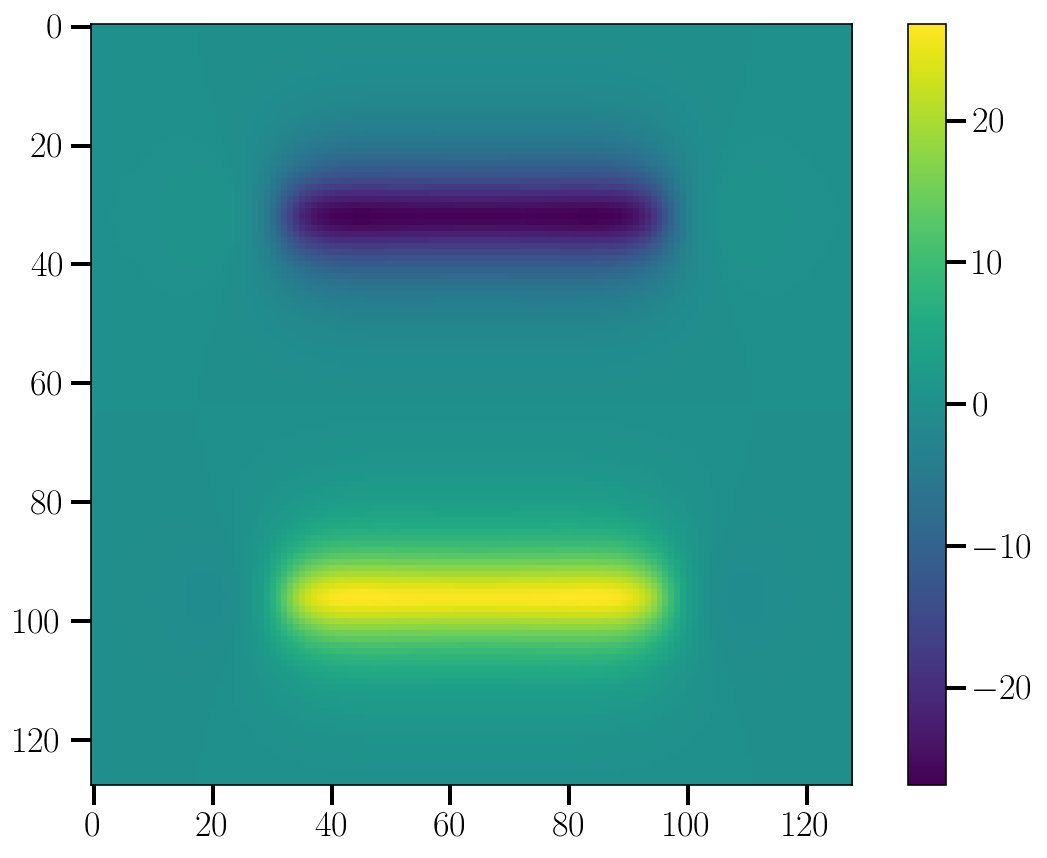

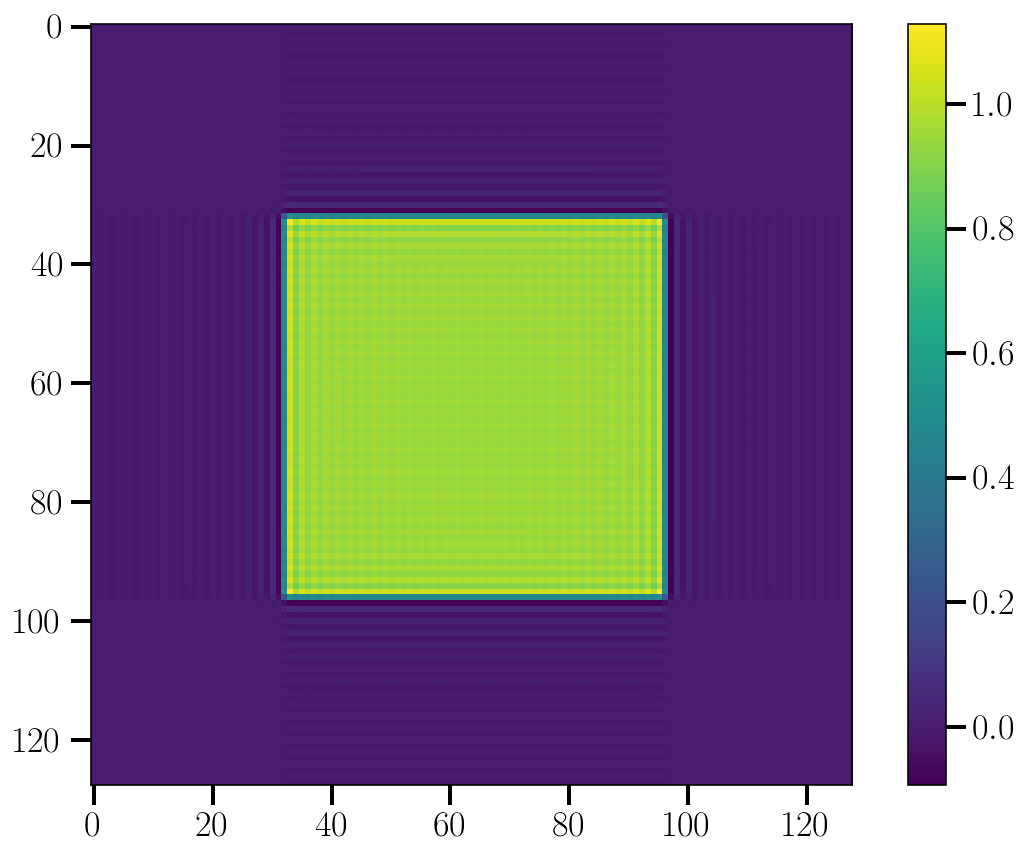

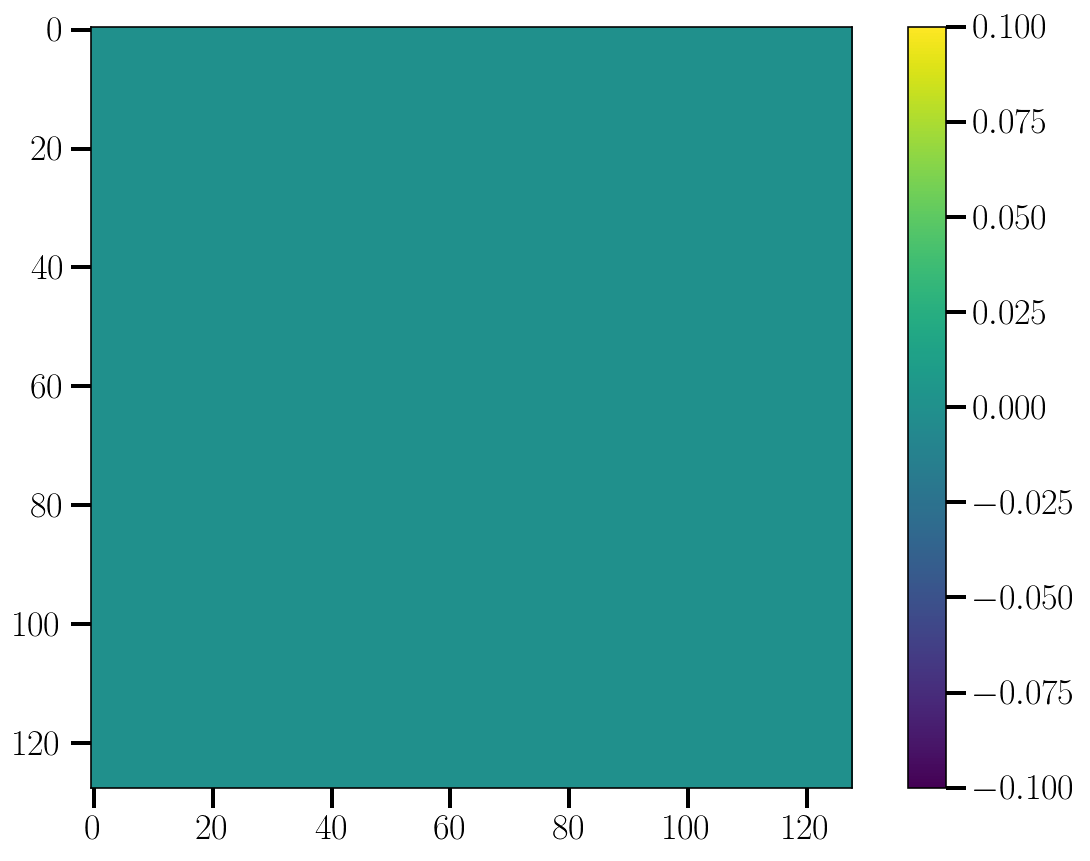

In [3134]:
from matplotlib import colors
np.fft.fftshift(pk_l1_q)
plt.figure(figsize=(10,7)) 
plt.imshow(np.fft.fftshift(np.fft.ifftn(qs[0]*pk_quad_conv_pp1(qs,0.01)*wq))[:,30,:].imag)
#plt.imshow(np.fft.fftshift(np.fft.ifftn(pk_quad_conv_pp1(qs,0.05)*wq))[100,:,:].real)
#plt.imshow(np.fft.fftshift(np.fft.ifftn(pk_quad_conv_pp(qz,0.01)*wq)[60,:,:].real))#,norm=colors.LogNorm())#wqpk_l1_q[62,:,:].imagnp.sum(pk_l1_q[32:96,32:96,32:96].imag,axis=0)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,7))
plt.imshow(np.fft.fftshift(np.fft.ifftn(wq)[:,30,:].real))#,norm=colors.LogNorm())#wqpk_l1_q[62,:,:].imagnp.sum(pk_l1_q[32:96,32:96,32:96].imag,axis=0)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,7))
plt.imshow(In_window[30,:,:])#,norm=colors.LogNorm())
plt.colorbar()
plt.show()

In [1566]:
from classy import Class
z= 0
#Start by specifying the cosmology - fiducial quijote...
Omega_b = 0.049#0.05
Omega_m = 0.3175
Omega_l = 0.682
Omega_cdm = Omega_m - Omega_b
h = 0.6711#0.7 #H0/100
A_s = 2.1e-9
n_s = 0.9624
a = 1/(1+z)
H  = 100.0*np.sqrt(Omega_m*(1.0+z)**3+Omega_l)*a #Value of H(z) in km/s/(Mpc/h)

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc

params = {   'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}
#Initialize the cosmology and compute everything
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=50000) #Mpc^-1
#z already specififed

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k /= h
Plin *= h**3
Pnonlin *= h**3

In [1567]:
def get_class_powerspectrum(kk,zz): #h are needed to convert to 1/Mpc for k then convert pk back to (Mpc/h)^3
     
    return np.array([cosmo.pk_lin(ki, zz) for ki in kk*h])*h**3

def get_pkinfo_z(k,z):
    Plin = get_class_powerspectrum(k,z)
    Pk = interpolate.interp1d(k,Plin)#Plin
    Pk_d = interpolate.interp1d(k,np.gradient(Plin,k))#(k[1:]+k[:-1])/2,np.diff(Plin)/np.diff(k)
    Pk_dd = interpolate.interp1d(k,np.gradient(Pk_d(k),k))
    Pk_ddd = interpolate.interp1d(k,np.gradient(Pk_dd(k),k))
    return Pk,Pk_d,Pk_dd,Pk_ddd

#so set parameters...
Pk_,Pk_d,Pk_dd,Pk_ddd = get_pkinfo_z(k,z)

In [420]:
# Lambda CDM
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy import interpolate
LCDM = Class()
LCDM.compute()
print(LCDM.get_current_derived_parameters)
baLCDM = LCDM.get_background()
print(baLCDM.keys())
f_cl = baLCDM['gr.fac. f']
z_cl = baLCDM['z']
H_cl = baLCDM['H [1/Mpc]'];H = interp1d(z_cl,H_cl*(1/(1+z_cl))/h,kind='cubic') # now in h/Mpc!
xi_cl = baLCDM['comov. dist.']; comoving_dist = interp1d(z_cl,xi_cl*h,kind='cubic') # just use class background as quick
f_intp = interp1d(z_cl,f_cl,kind='cubic')#get f #omega_mz = Omega_m *(1+zt)**3 /(Omega_m *(1+zt)**3 + Omega_l)
f = f_intp(0)

<built-in method get_current_derived_parameters of classy.Class object at 0x557aefc3cc00>
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [2962]:
b1=1
def pk_mono(kk,sigma):
    Pks = Pk_(kk)
    return b1**2 *Pks+ (2*b1*f*Pks)/3 + (f**2 *Pks)/5

def pk_mono_dfog(kk,sigma):
    Pks = Pk_(kk)
    return Pks*np.exp(-kk**2*sigma**2)*(np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4 + 4*b1*f*kk**2*sigma**2 + 3*f**2) - 6*f**2*kk*sigma - 4*f*kk**3*sigma**3*(2*b1 + f))/(8*kk**5*sigma**5)  
    
def pk_mono_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(4*t**2 - 4*t - 1) + 4*b1*f*kk**3*sigma**3*(-4*kk**6*sigma**6 - 14*kk**4*sigma**4 - 33*kk**2*sigma**2 + t**2*(16*kk**6*sigma**6 + 16*kk**4*sigma**4 + 48*kk**2*sigma**2 + 72) - t*(16*kk**6*sigma**6 + 16*kk**4*sigma**4 + 48*kk**2*sigma**2 + 72) - 54) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(12*b1**2*kk**8*sigma**8 - 6*b1*f*kk**2*sigma**2*(kk**2*sigma**2 + 24*t**2 - 24*t - 18) + f**2*(7*kk**4*sigma**4 - 153*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 540) + t*(-24*kk**2*sigma**2 + 540) + 765)) + 2*f**2*kk*sigma*(-4*kk**8*sigma**8 - 22*kk**6*sigma**6 - 109*kk**4*sigma**4 - 357*kk**2*sigma**2 + t**2*(16*kk**8*sigma**8 + 32*kk**6*sigma**6 + 128*kk**4*sigma**4 + 336*kk**2*sigma**2 + 540) - t*(16*kk**8*sigma**8 + 32*kk**6*sigma**6 + 128*kk**4*sigma**4 + 336*kk**2*sigma**2 + 540) - 765)) + kk*(Pkd*(-8*b1**2*kk**5*sigma**5*(8*kk**2*sigma**2 + 3)*(4*t**2 - 4*t - 3) + 8*b1*f*kk**3*sigma**3*(24*kk**4*sigma**4 + 76*kk**2*sigma**2 - t**2*(64*kk**4*sigma**4 + 112*kk**2*sigma**2 + 180) + t*(64*kk**4*sigma**4 + 112*kk**2*sigma**2 + 180) + 135) - np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-12*b1**2*kk**4*sigma**4*(8*kk**4*sigma**4 - 6*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 + 4) - t*(8*kk**2*sigma**2 + 4) - 3) + 4*b1*f*kk**2*sigma**2*(8*kk**4*sigma**4 - 14*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 - 180) + t*(-8*kk**2*sigma**2 + 180) + 135) + f**2*(56*kk**4*sigma**4 - 666*kk**2*sigma**2 + t**2*(120*kk**2*sigma**2 - 1620) - t*(120*kk**2*sigma**2 - 1620) + 2295)) + 2*f**2*kk*sigma*(48*kk**6*sigma**6 + 224*kk**4*sigma**4 + 864*kk**2*sigma**2 - t**2*(128*kk**6*sigma**6 + 352*kk**4*sigma**4 + 960*kk**2*sigma**2 + 1620) + t*(128*kk**6*sigma**6 + 352*kk**4*sigma**4 + 960*kk**2*sigma**2 + 1620) + 2295)) + Pkdd*kk*(8*b1**2*kk**5*sigma**5*(2*kk**2*sigma**2 + 12*t**2 - 12*t - 9) + 8*b1*f*kk**3*sigma**3*(-10*kk**2*sigma**2 + t**2*(16*kk**2*sigma**2 + 36) - t*(16*kk**2*sigma**2 + 36) - 27) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(4*kk**4*sigma**4 - 8*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 - 12) + t*(-8*kk**2*sigma**2 + 12) + 9) - 4*b1*f*kk**2*sigma**2*(4*kk**4*sigma**4 + 8*kk**2*sigma**2 + t**2*(-8*kk**2*sigma**2 + 36) + t*(8*kk**2*sigma**2 - 36) - 27) + f**2*(28*kk**4*sigma**4 - 120*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 180) + t*(-24*kk**2*sigma**2 + 180) + 255)) + 2*f**2*kk*sigma*(-16*kk**4*sigma**4 - 50*kk**2*sigma**2 + t**2*(32*kk**4*sigma**4 + 96*kk**2*sigma**2 + 180) - t*(32*kk**4*sigma**4 + 96*kk**2*sigma**2 + 180) - 255))))/(128*d**2*kk**9*sigma**7)

def pk_quad(kk,sigma):
    Pks = Pk_(kk)
    return (4*b1*f*Pks)/3 + (4*f**2 *Pks)/7

def pk_quad_dfog(kk,sigma):
    Pks = Pk_(kk)
    return  5*Pks*np.exp(-kk**2*sigma**2)*(-np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(8*b1**2*kk**6*sigma**6 + 4*b1*kk**4*sigma**4*(-3*b1 + 2*f) - 45*f**2 + 6*f*kk**2*sigma**2*(-6*b1 + f)) - 90*f**2*kk*sigma - 24*f*kk**3*sigma**3*(3*b1 + 2*f) - kk**5*sigma**5*(24*b1**2 + 32*b1*f + 16*f**2))/(32*kk**7*sigma**7)

def pk_quad_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return 5*np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(-4*kk**2*sigma**2 + t**2*(16*kk**2*sigma**2 + 24) - t*(16*kk**2*sigma**2 + 24) - 15) + 4*b1*f*kk**3*sigma**3*(-16*kk**8*sigma**8 - 80*kk**6*sigma**6 - 180*kk**4*sigma**4 - 381*kk**2*sigma**2 + t**2*(64*kk**8*sigma**8 + 160*kk**6*sigma**6 + 912*kk**4*sigma**4 + 2808*kk**2*sigma**2 + 5400) - t*(64*kk**8*sigma**8 + 160*kk**6*sigma**6 + 912*kk**4*sigma**4 + 2808*kk**2*sigma**2 + 5400) - 450) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(12*b1**2*kk**8*sigma**8*(-2*kk**2*sigma**2 - 8*t**2 + 8*t + 5) + 6*b1*f*kk**2*sigma**2*(2*kk**4*sigma**4 + 27*kk**2*sigma**2 + t**2*(264*kk**2*sigma**2 - 1800) - t*(264*kk**2*sigma**2 - 1800) + 150) + f**2*(-14*kk**6*sigma**6 + 297*kk**4*sigma**4 - 2385*kk**2*sigma**2 - t**2*(264*kk**4*sigma**4 - 9720*kk**2*sigma**2 + 56700) + t*(264*kk**4*sigma**4 - 9720*kk**2*sigma**2 + 56700) + 12285)) + 2*f**2*kk*sigma*(-16*kk**10*sigma**10 - 112*kk**8*sigma**8 - 484*kk**6*sigma**6 - 1983*kk**4*sigma**4 - 5805*kk**2*sigma**2 + t**2*(64*kk**10*sigma**10 + 224*kk**8*sigma**8 + 1904*kk**6*sigma**6 + 8904*kk**4*sigma**4 + 28080*kk**2*sigma**2 + 56700) - t*(64*kk**10*sigma**10 + 224*kk**8*sigma**8 + 1904*kk**6*sigma**6 + 8904*kk**4*sigma**4 + 28080*kk**2*sigma**2 + 56700) - 12285)) + kk*(Pkd*(8*b1**2*kk**5*sigma**5*(24*kk**4*sigma**4 + 138*kk**2*sigma**2 - t**2*(128*kk**4*sigma**4 + 984*kk**2*sigma**2 + 540) + t*(128*kk**4*sigma**4 + 984*kk**2*sigma**2 + 540) + 45) - 8*b1*f*kk**3*sigma**3*(-96*kk**6*sigma**6 - 328*kk**4*sigma**4 - 858*kk**2*sigma**2 + t**2*(256*kk**6*sigma**6 + 1792*kk**4*sigma**4 + 6264*kk**2*sigma**2 + 13500) - t*(256*kk**6*sigma**6 + 1792*kk**4*sigma**4 + 6264*kk**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-12*b1**2*kk**4*sigma**4*(16*kk**6*sigma**6 - 20*kk**4*sigma**4 + 36*kk**2*sigma**2 + t**2*(144*kk**4*sigma**4 - 208*kk**2*sigma**2 - 180) - t*(144*kk**4*sigma**4 - 208*kk**2*sigma**2 - 180) + 15) + 4*b1*f*kk**2*sigma**2*(16*kk**6*sigma**6 + 44*kk**4*sigma**4 - 108*kk**2*sigma**2 + t**2*(16*kk**4*sigma**4 - 2736*kk**2*sigma**2 + 13500) - t*(16*kk**4*sigma**4 - 2736*kk**2*sigma**2 + 13500) - 1125) + f**2*(112*kk**6*sigma**6 - 1548*kk**4*sigma**4 + 10620*kk**2*sigma**2 + t**2*(1392*kk**4*sigma**4 - 36720*kk**2*sigma**2 + 170100) - t*(1392*kk**4*sigma**4 - 36720*kk**2*sigma**2 + 170100) - 36855)) + 2*f**2*kk*sigma*(192*kk**8*sigma**8 + 896*kk**6*sigma**6 + 4296*kk**4*sigma**4 + 13950*kk**2*sigma**2 - t**2*(512*kk**8*sigma**8 + 4096*kk**6*sigma**6 + 22272*kk**4*sigma**4 + 76680*kk**2*sigma**2 + 170100) + t*(512*kk**8*sigma**8 + 4096*kk**6*sigma**6 + 22272*kk**4*sigma**4 + 76680*kk**2*sigma**2 + 170100) + 36855)) - Pkdd*kk*(8*b1**2*kk**5*sigma**5*(4*kk**4*sigma**4 + 12*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 540) + t*(-24*kk**2*sigma**2 + 540) + 45) - 8*b1*f*kk**3*sigma**3*(-28*kk**4*sigma**4 - 96*kk**2*sigma**2 + t**2*(64*kk**4*sigma**4 + 648*kk**2*sigma**2 + 2700) - t*(64*kk**4*sigma**4 + 648*kk**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(8*kk**6*sigma**6 - 4*kk**4*sigma**4 + 18*kk**2*sigma**2 + t**2*(112*kk**4*sigma**4 - 384*kk**2*sigma**2 + 540) - t*(112*kk**4*sigma**4 - 384*kk**2*sigma**2 + 540) - 45) - 4*b1*f*kk**2*sigma**2*(8*kk**6*sigma**6 + 4*kk**4*sigma**4 - 54*kk**2*sigma**2 - t**2*(112*kk**4*sigma**4 - 1152*kk**2*sigma**2 + 2700) + t*(112*kk**4*sigma**4 - 1152*kk**2*sigma**2 + 2700) + 225) + f**2*(56*kk**6*sigma**6 - 492*kk**4*sigma**4 + 1950*kk**2*sigma**2 + t**2*(336*kk**4*sigma**4 - 5760*kk**2*sigma**2 + 18900) - t*(336*kk**4*sigma**4 - 5760*kk**2*sigma**2 + 18900) - 4095)) + 2*f**2*kk*sigma*(64*kk**6*sigma**6 + 284*kk**4*sigma**4 + 780*kk**2*sigma**2 - t**2*(128*kk**6*sigma**6 + 1536*kk**4*sigma**4 + 6840*kk**2*sigma**2 + 18900) + t*(128*kk**6*sigma**6 + 1536*kk**4*sigma**4 + 6840*kk**2*sigma**2 + 18900) + 4095))))/(512*d**2*kk**11*sigma**9)

def pk_dipo(kk,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return-4*f*(3*Pks+ Pkd*kk)*(7*b1 + 3*f)*(2*t - 1)/(35*d*kk)

def pk_octo(kk,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return -4*1j*f*(2*t - 1)*(Pkd*kk*(9*b1 + f) - Pks*(18*b1 + 22*f))/(45*d*kk)

def pk_dipo_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return 3*1j*np.exp(-kk**2*sigma**2)*(2*t - 1)*(np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(Pkd*kk*(-8*b1**2*kk**6*sigma**6 + 4*b1*kk**4*sigma**4*(3*b1 - 2*f) + 45*f**2 - 6*f*kk**2*sigma**2*(-6*b1 + f)) - 4*Pks*(4*b1**2*kk**6*sigma**6 + 45*f**2 - 3*f*kk**2*sigma**2*(-6*b1 + f))) + 2*kk*sigma*(-Pkd*kk*(45*f**2 + 12*f*kk**2*sigma**2*(3*b1 + 2*f) + kk**4*sigma**4*(12*b1**2 + 16*b1*f + 8*f**2)) + 4*Pks*(45*f**2 + 2*f*kk**4*sigma**4*(6*b1 + 5*f) + 9*f*kk**2*sigma**2*(2*b1 + 3*f) + 4*kk**6*sigma**6*(b1 + f)**2)))/(32*d*kk**8*sigma**7)
            
def pk_octo_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return  7*1j*np.exp(-kk**2*sigma**2)*(2*t - 1)*(Pkd*kk*(3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(16*b1**2*kk**8*sigma**8 + 16*b1*kk**6*sigma**6*(-4*b1 + f) + 875*f**2 + f*kk**2*sigma**2*(500*b1 - 240*f) + kk**4*sigma**4*(100*b1**2 - 192*b1*f + 12*f**2)) - 5250*f**2*kk*sigma - 20*f*kk**3*sigma**3*(150*b1 + 103*f) - kk**7*sigma**7*(16*b1**2 + 128*b1*f + 64*f**2) - kk**5*sigma**5*(600*b1**2 + 848*b1*f + 512*f**2)) + 4*Pks*(-3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-8*b1**2*kk**8*sigma**8 + 20*b1**2*kk**6*sigma**6 + 875*f**2 + 6*f*kk**4*sigma**4*(-6*b1 + f) + f*kk**2*sigma**2*(250*b1 - 165*f)) + 5250*f**2*kk*sigma + 8*f*kk**5*sigma**5*(98*b1 + 97*f) + 10*f*kk**3*sigma**3*(150*b1 + 251*f) + 32*kk**9*sigma**9*(b1 + f)**2 + kk**7*sigma**7*(120*b1**2 + 256*b1*f + 160*f**2)))/(128*d*kk**10*sigma**9)


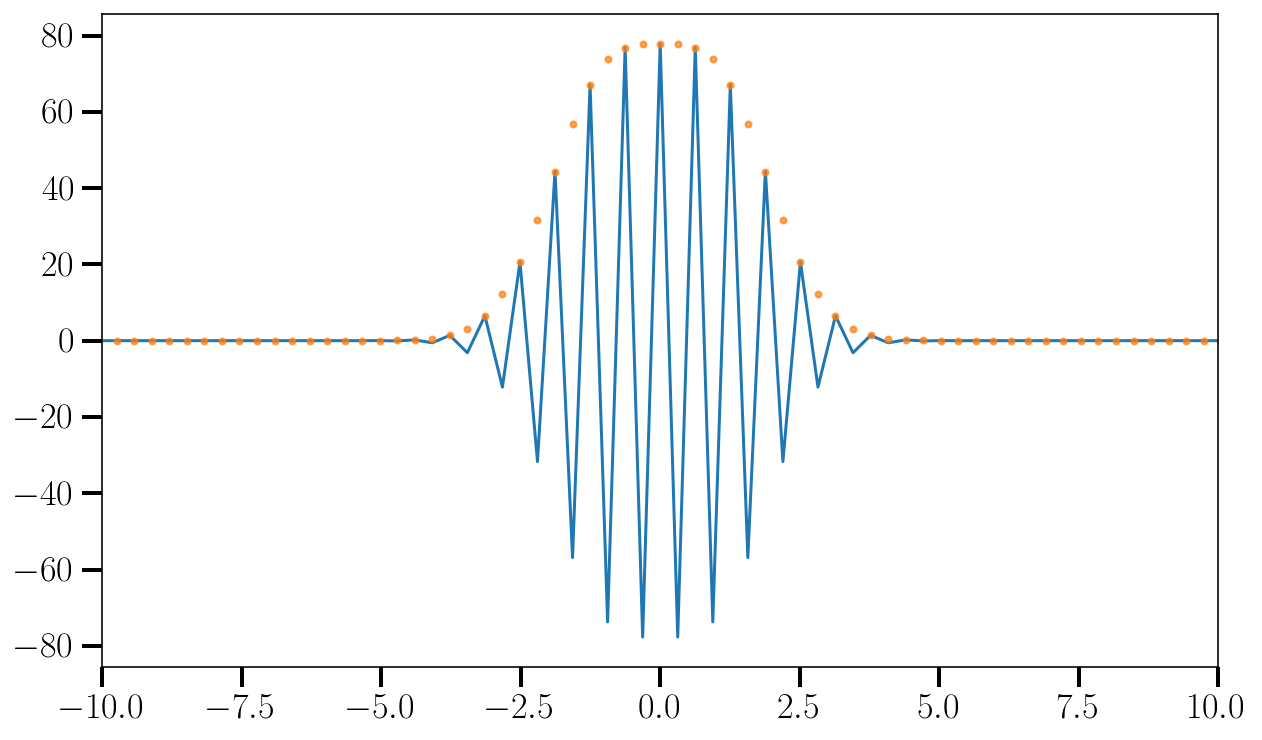

In [964]:
d_values = np.linspace(-10, 10, 1024)  # Example d values
real_coeffs = np.exp(-0.5 * d_values**2)*np.cos(d_values)  # Example real coefficients

# Define the parameters
N = len(d_values)  # Number of samples
L = 20.0  # Length of the domain
fft_ = np.fft.fft(real_coeffs)
x = np.linspace(-L/2, L/2, N)
dx = x[1] - x[0]
k = 2*np.pi*np.fft.fftfreq(N,d=20/1024)
fourier_sum = np.zeros(len(k),dtype=np.complex64)
for i,kk in enumerate(k):
    fourier_sum[i] = np.sum(real_coeffs * np.exp(-1j * kk * x)) 
    
plt.figure(figsize=(10, 6))
plt.plot(np.fft.fftshift(k), (np.fft.fftshift(fft_)).real,'-')
plt.plot(k, (fourier_sum).real, '.',label='Real Part',alpha=0.7)
plt.xlim(-10,10)
plt.show()

fft_real = np.fft.fft((fft_))
inv_fourier_sum = np.zeros(len(k),dtype=np.complex64)
for i,xx in enumerate(x):
    inv_fourier_sum[i] = np.sum(fourier_sum * np.exp(-1j * k * xx)) 
    
plt.figure(figsize=(10, 6))
plt.plot(d_values, fft_real,'.')
plt.plot(d_values, np.real(inv_fourier_sum),'.',alpha=0.7)
plt.show()  

In [70]:
f = f_intp(0)
b1 =1 

0.5222389117917002
